In [ ]:
#!/usr/bin/env python
# validation.ipynb
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Import model components
import sys
sys.path.append("~/Project/kurucz1/")
%reload_ext autoreload
%autoreload 2
from model import AtmosphereNet, AtmosphereNetMLP, AtmosphereNetMLPtau, KuruczDataset
from train import custom_loss, load_dataset_file
from physics import calculate_gradient_torch

# retina display
%config InlineBackend.figure_format = 'retina'


# Load dataset
def load_validation_data(filepath, device='cpu'):
    dataset = load_dataset_file(filepath, device)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=32, shuffle=False, num_workers=0
    )
    return dataloader, dataset

# Load model
def load_trained_model(model_path, hidden_size, depth_points, device):
    # model = AtmosphereNet(
    #     input_size=5, 
    #     hidden_size=hidden_size,
    #     output_size=6,
    #     depth_points=depth_points
    # ).to(device)
    # model = AtmosphereNetMLP(
    #     input_size=5,
    #     hidden_size=hidden_size,
    #     output_size=6,
    #     depth_points=depth_points
    # ).to(device)    
    model = AtmosphereNetMLPtau(
        input_size=5,
        hidden_size=hidden_size,
        output_size=6,
        depth_points=depth_points
    ).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, checkpoint['epoch'], checkpoint['loss']

# Validate model
def validate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    param_losses = {'RHOX': 0.0, 'T': 0.0, 'P': 0.0, 
                   'XNE': 0.0, 'ABROSS': 0.0, 'ACCRAD': 0.0}
    
    all_inputs = []
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            all_inputs.append(inputs.cpu())
            outputs = model(inputs)
            loss, batch_param_losses = custom_loss(outputs, targets)
            
            total_loss += loss.item()
            for param, param_loss in batch_param_losses.items():
                param_losses[param] += param_loss.item()
            
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    avg_loss = total_loss / len(dataloader)
    avg_param_losses = {k: v / len(dataloader) for k, v in param_losses.items()}
    
    all_inputs = torch.cat(all_inputs, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return avg_loss, avg_param_losses, all_inputs, all_predictions, all_targets

# Calculate metrics
def calculate_metrics(predictions, targets):
    param_names = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD']
    metrics = {}
    
    for i, param in enumerate(param_names):
        pred = predictions[:, :, i]
        targ = targets[:, :, i]
        
        mse = torch.mean((pred - targ) ** 2).item()
        rmse = np.sqrt(mse)
        mae = torch.mean(torch.abs(pred - targ)).item()
        
        ss_tot = torch.sum((targ - torch.mean(targ)) ** 2).item()
        ss_res = torch.sum((targ - pred) ** 2).item()
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        
        metrics[param] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2
        }
    return metrics

In [2]:
# model_path   = "/Users/jdli/Project/kurucz1/checkpoints_v0324tau/best_model.pt"
model_path = "/Users/jdli/Project/kurucz1/checkpoints_v0324tau_full/best_model.pt"
# model_path = "/Users/jdli/Project/kurucz1/checkpoints_v0320tau_hydro/best_model.pt"
# model_path = "/Users/jdli/Project/kurucz1/checkpoints_v0322tau_hydro/best_model.pt"
dataset_path = "/Users/jdli/Project/kurucz1/data/kurucz_vturb_0p5_tau_v2.pt"

hidden_size = 128
device = torch.device('cpu')

# Load dataset and model
dataloader, dataset = load_validation_data(dataset_path, device)
model, epoch, train_loss = load_trained_model(
    model_path, hidden_size, dataset.max_depth_points, device
)
print(f"Model loaded: trained for {epoch} epochs, final loss: {train_loss:.6f}")

# Validate model
val_loss, param_losses, inputs, predictions, targets = validate_model(model, dataloader, device)
print(f"Validation loss: {val_loss:.6f}")
for param, loss in param_losses.items():
    print(f"{param} loss: {loss:.6f}")

/Users/jdli/Project/kurucz1/train.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(filepath, map_location=device)
/var/folders/9x/hr77dpxn3rg_yz8

Model loaded: trained for 561 epochs, final loss: 0.008491
Validation loss: 0.008806
RHOX loss: 0.001532
T loss: 0.000493
P loss: 0.001101
XNE loss: 0.000757
ABROSS loss: 0.004680
ACCRAD loss: 0.000243


Validation loss: 0.008806
RHOX loss: 0.001532
T loss: 0.000493
P loss: 0.001101
XNE loss: 0.000757
ABROSS loss: 0.004680
ACCRAD loss: 0.000243

In [ ]:
# Calculate metrics
metrics = calculate_metrics(predictions, targets)
for param, param_metrics in metrics.items():
    print(f"\n{param} metrics:")

    for metric_name, value in param_metrics.items():
        print(f"{metric_name}: {value:.6f}")
        


RHOX metrics:
  MSE: 0.000306
  RMSE: 0.017503
  MAE: 0.010771
  R²: 0.997965

T metrics:
  MSE: 0.000049
  RMSE: 0.007020
  MAE: 0.004780
  R²: 0.997626

P metrics:
  MSE: 0.000220
  RMSE: 0.014838
  MAE: 0.009627
  R²: 0.997713

XNE metrics:
  MSE: 0.000757
  RMSE: 0.027513
  MAE: 0.018345
  R²: 0.992636

ABROSS metrics:
  MSE: 0.000468
  RMSE: 0.021631
  MAE: 0.013593
  R²: 0.996062

ACCRAD metrics:
  MSE: 0.000243
  RMSE: 0.015595
  MAE: 0.011479
  R²: 0.987222


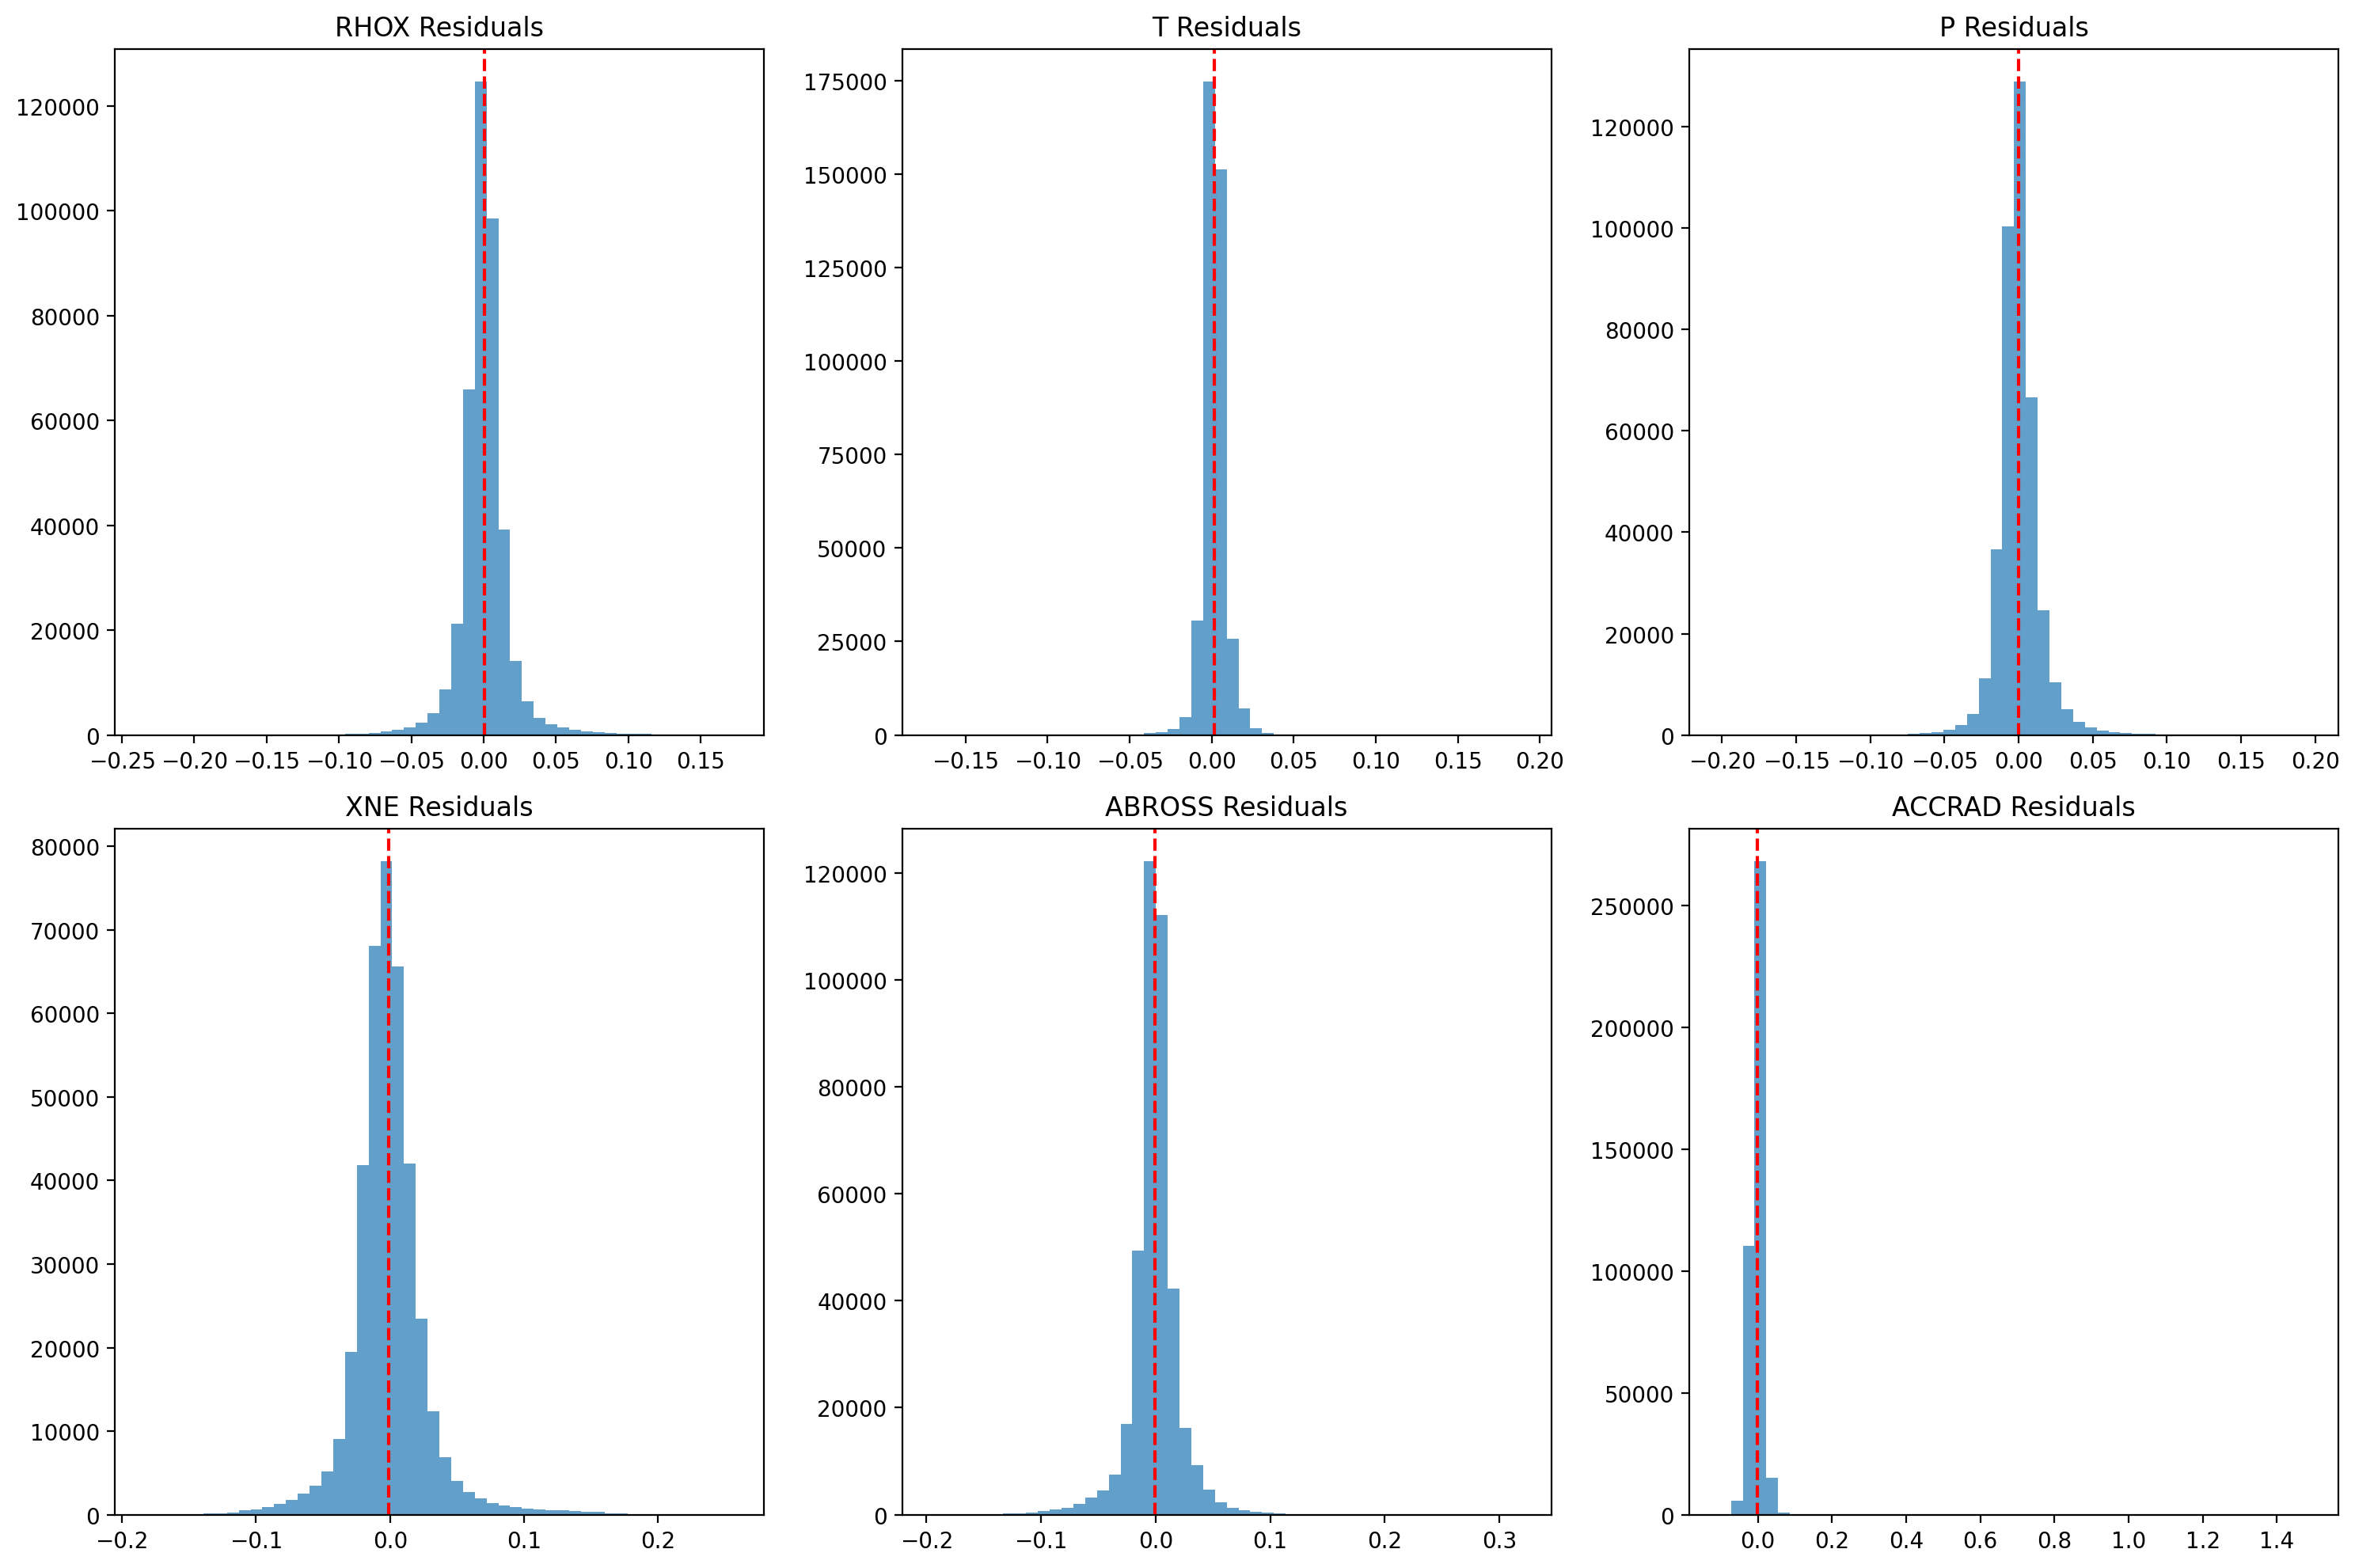

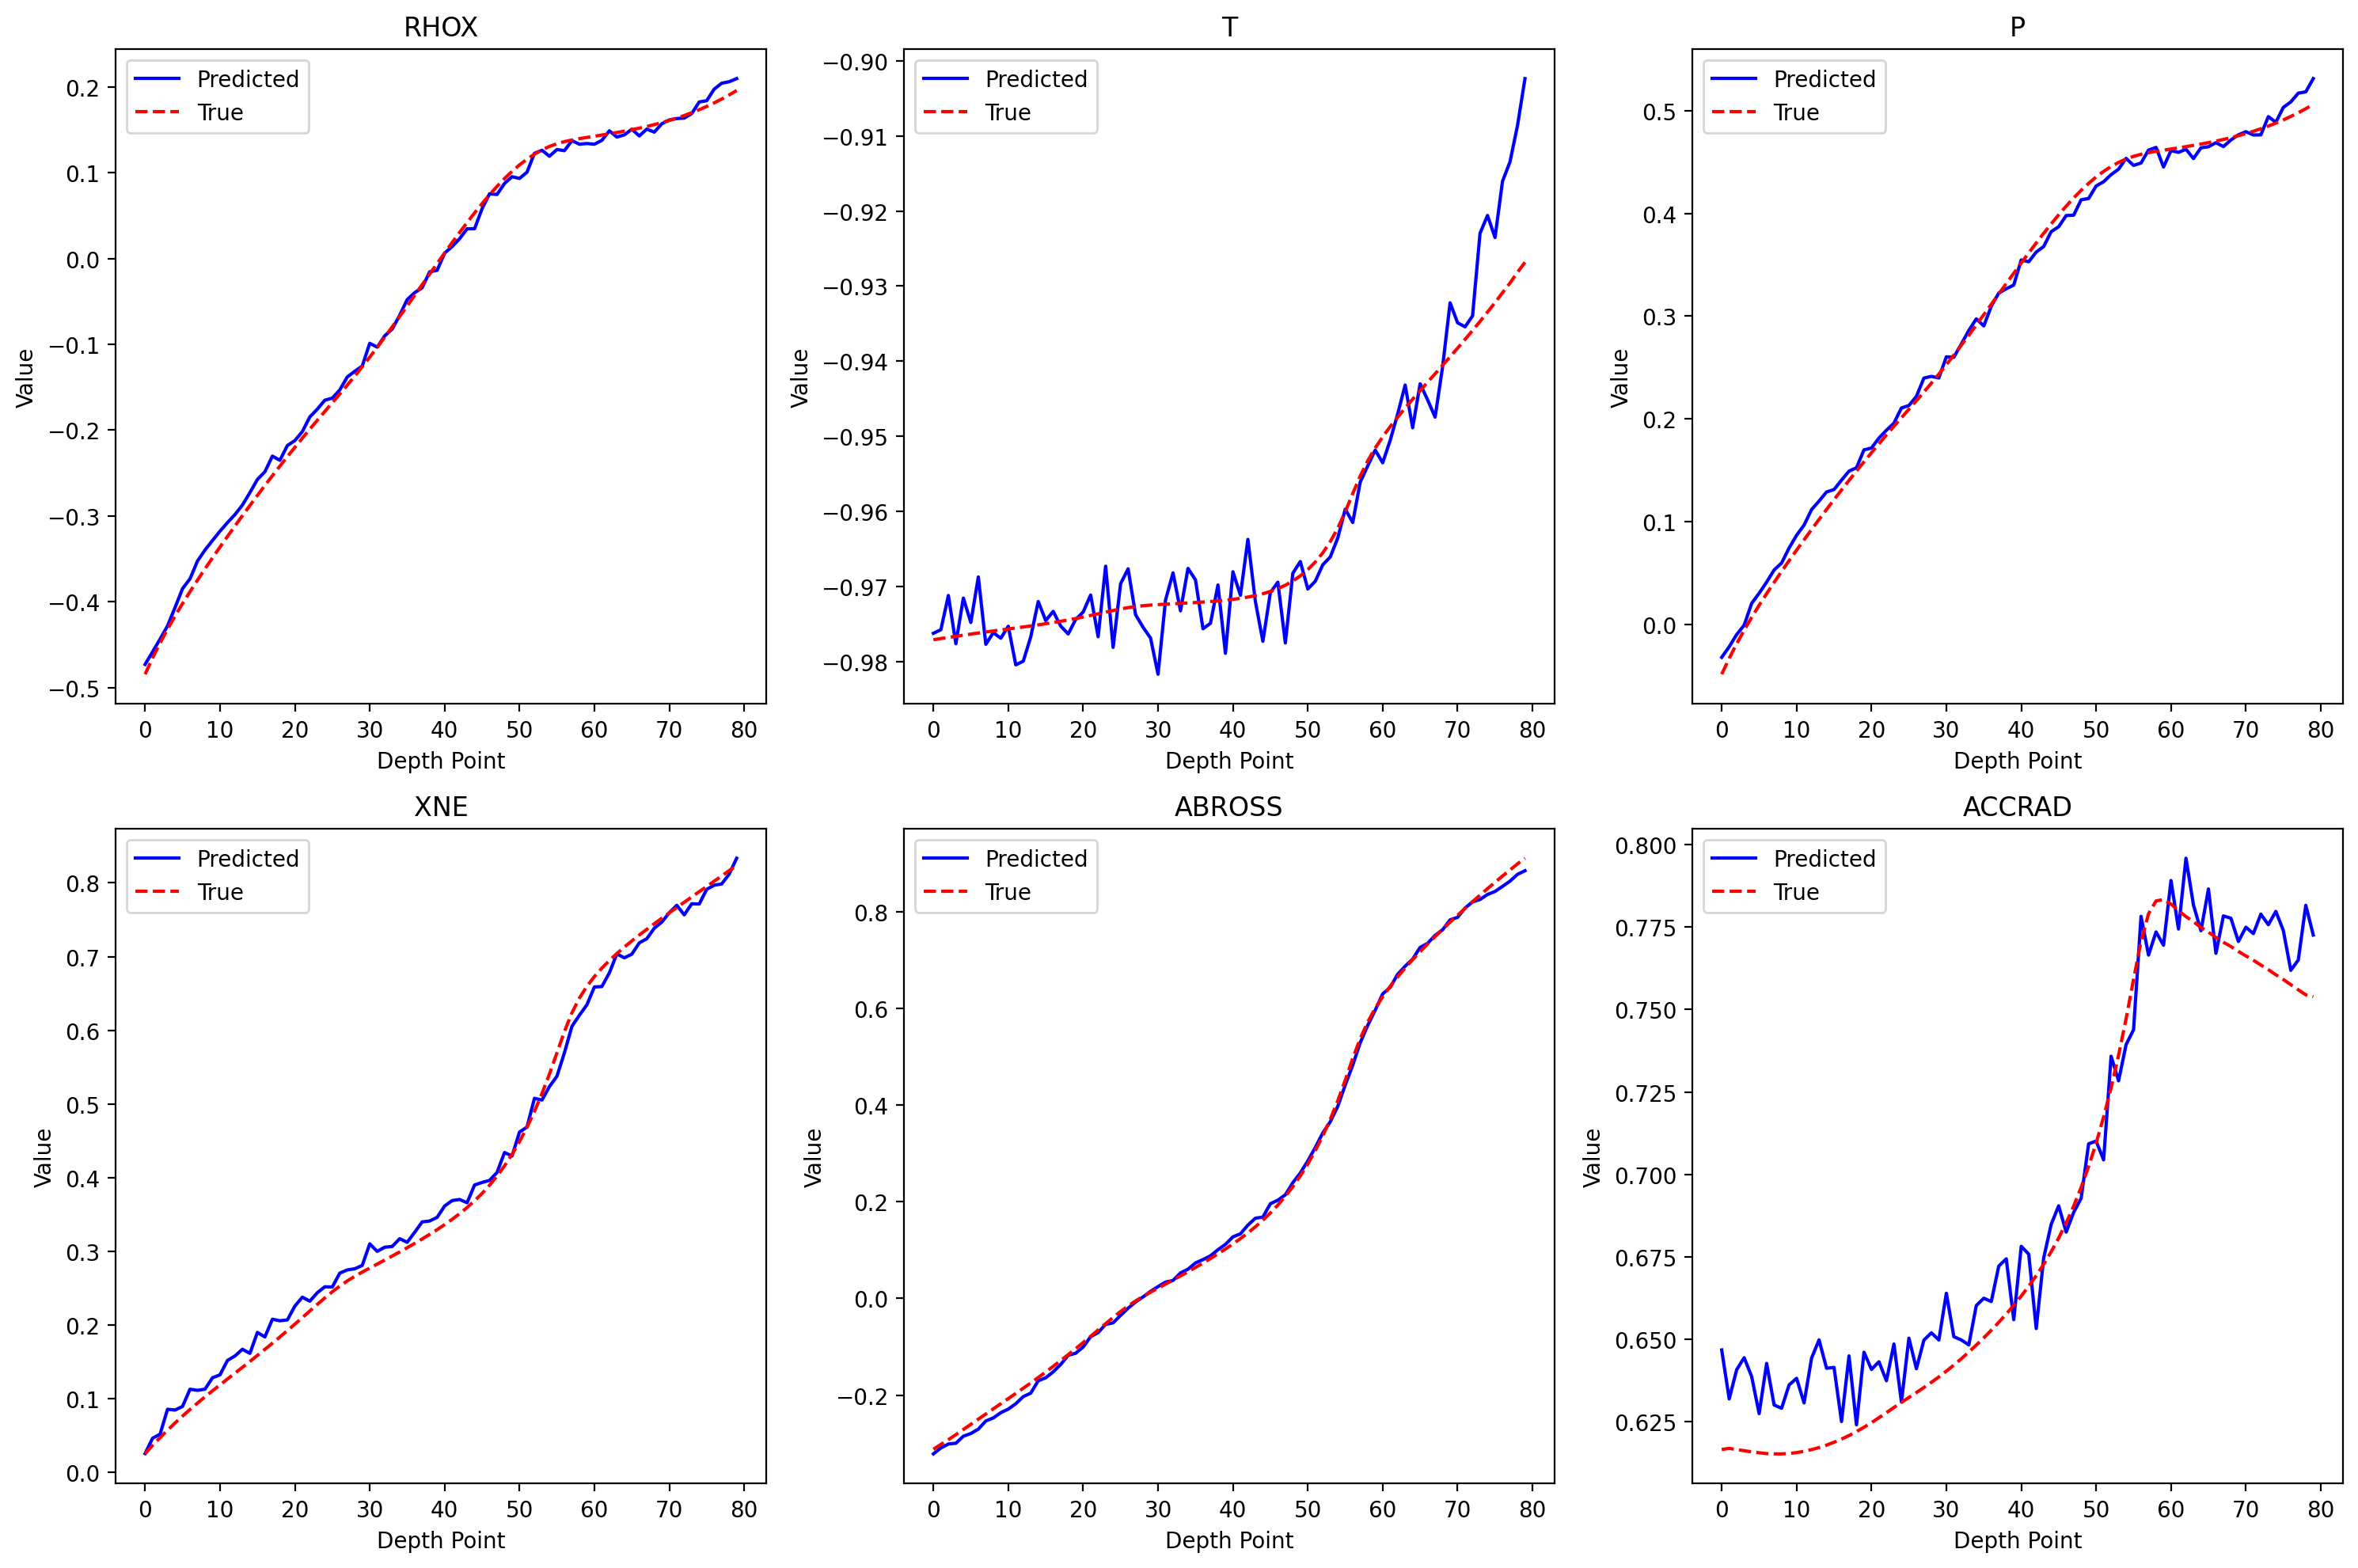

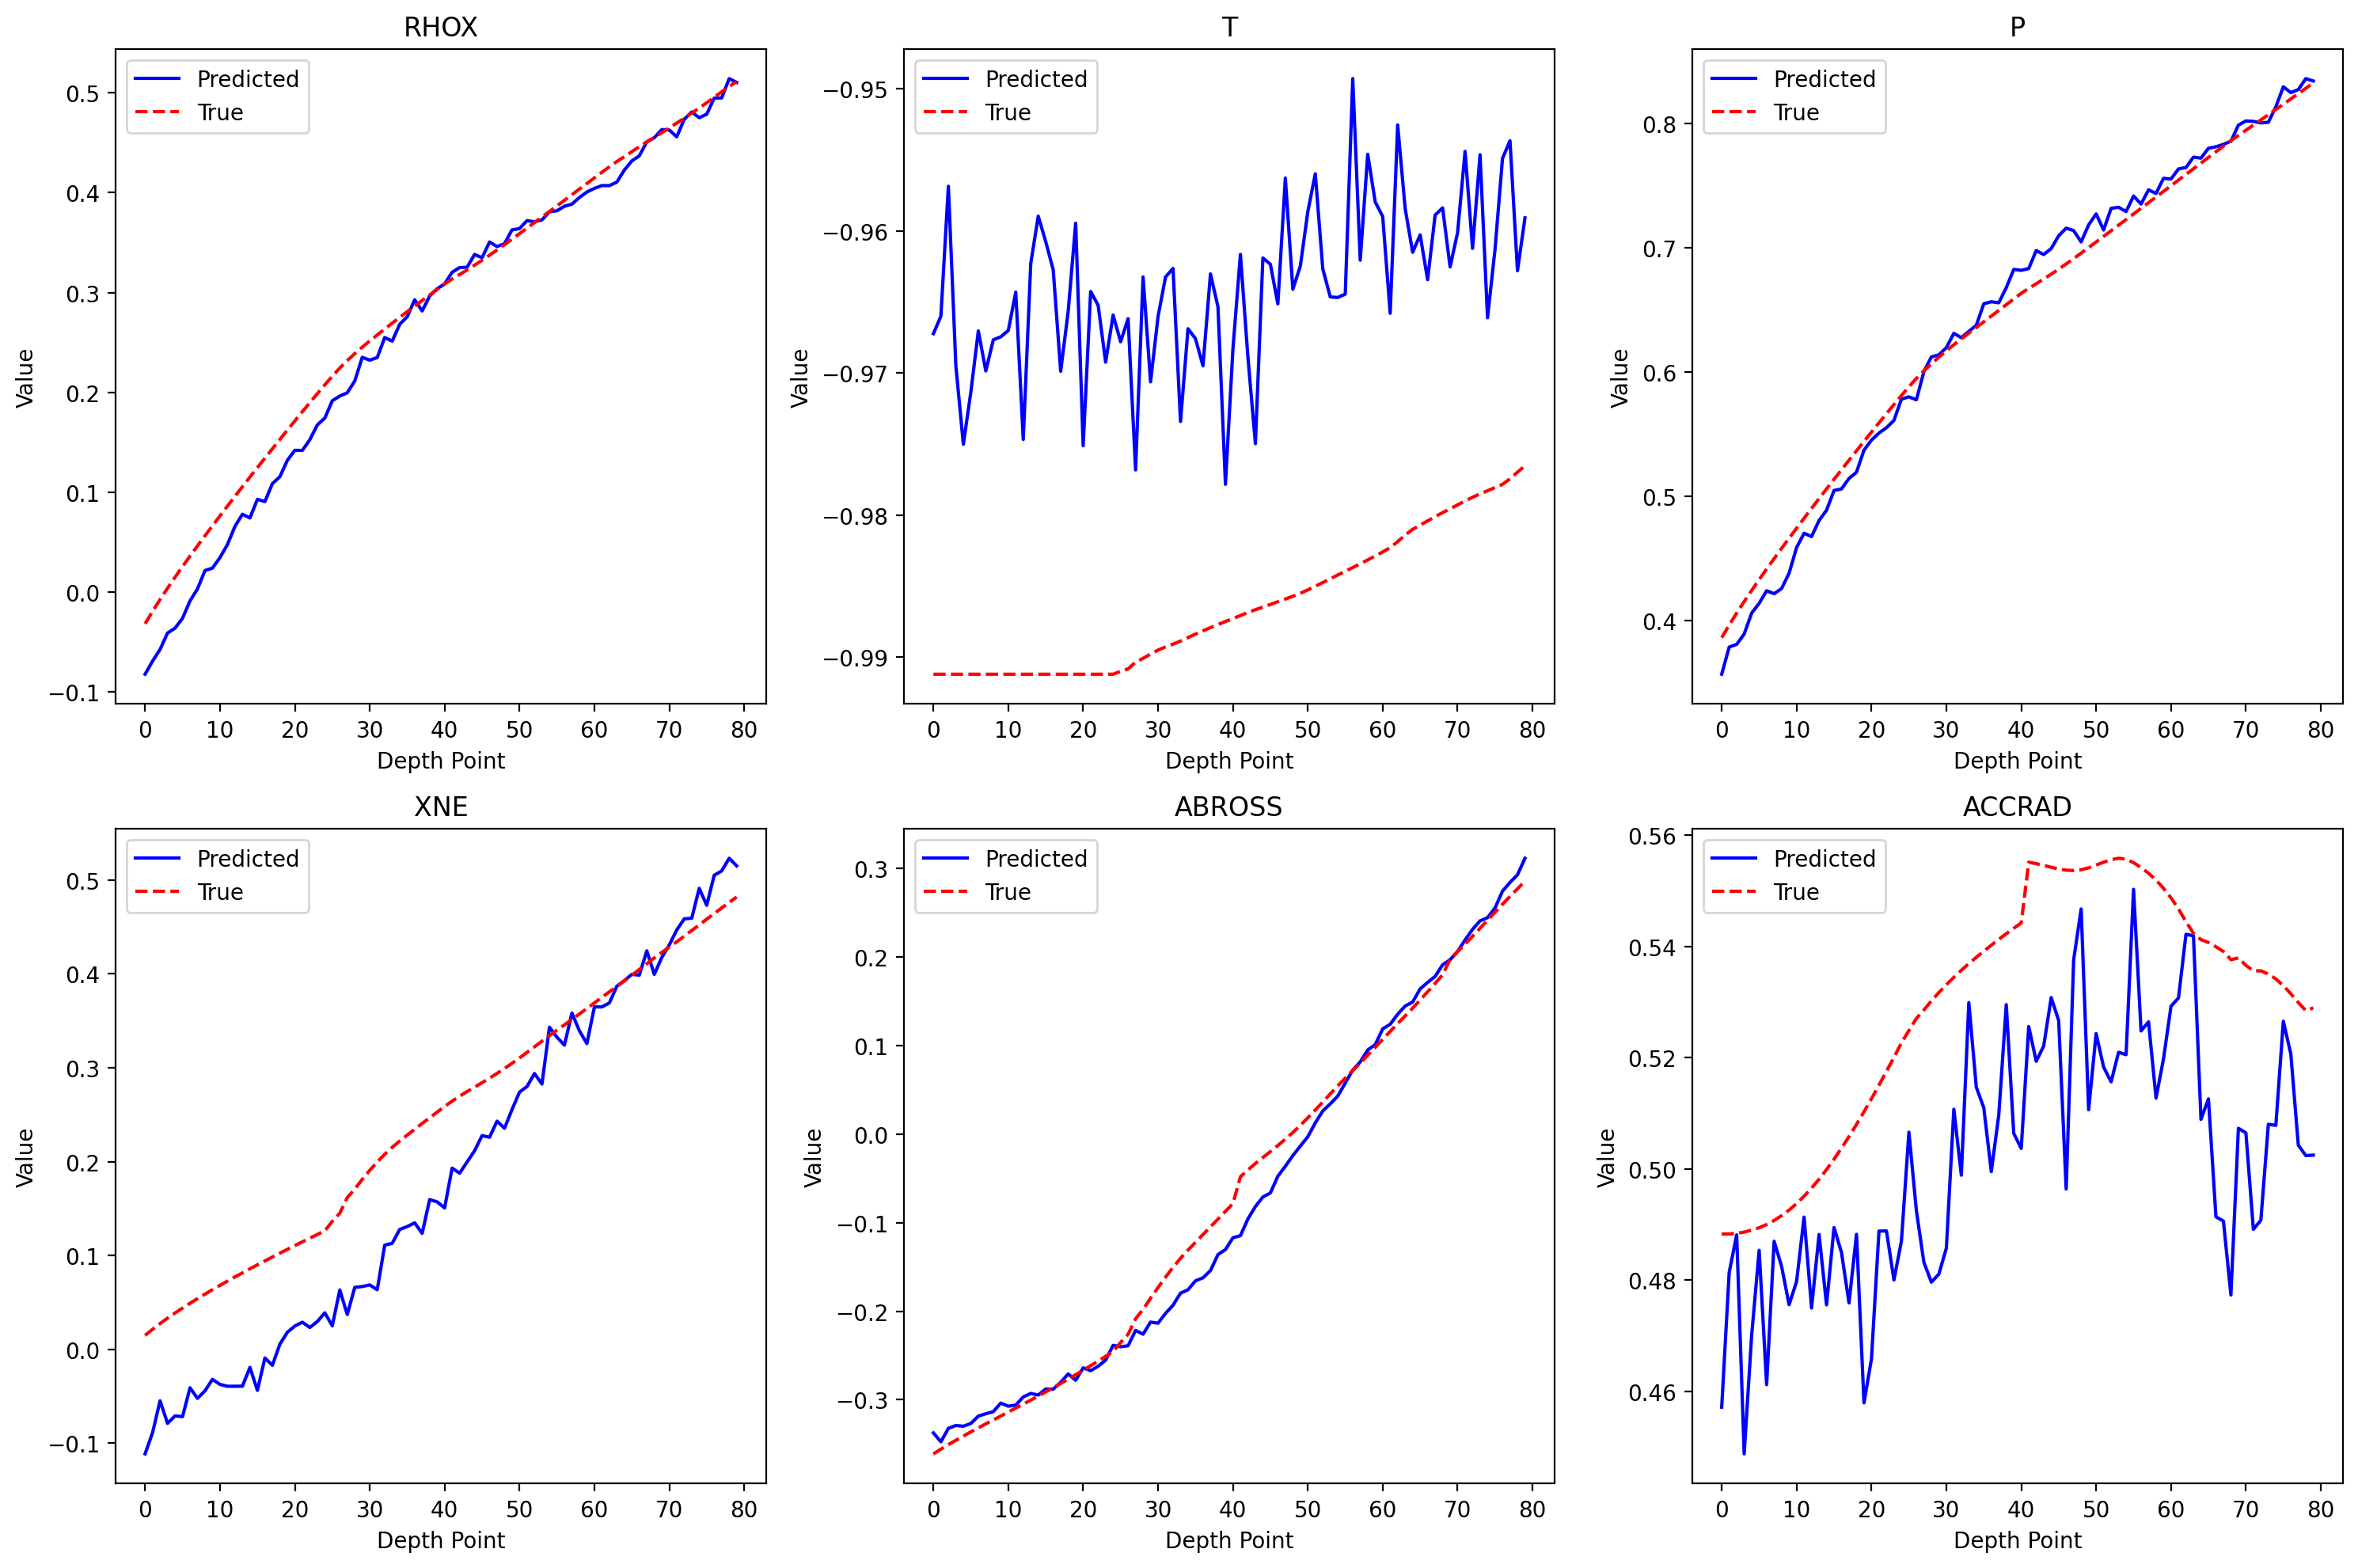

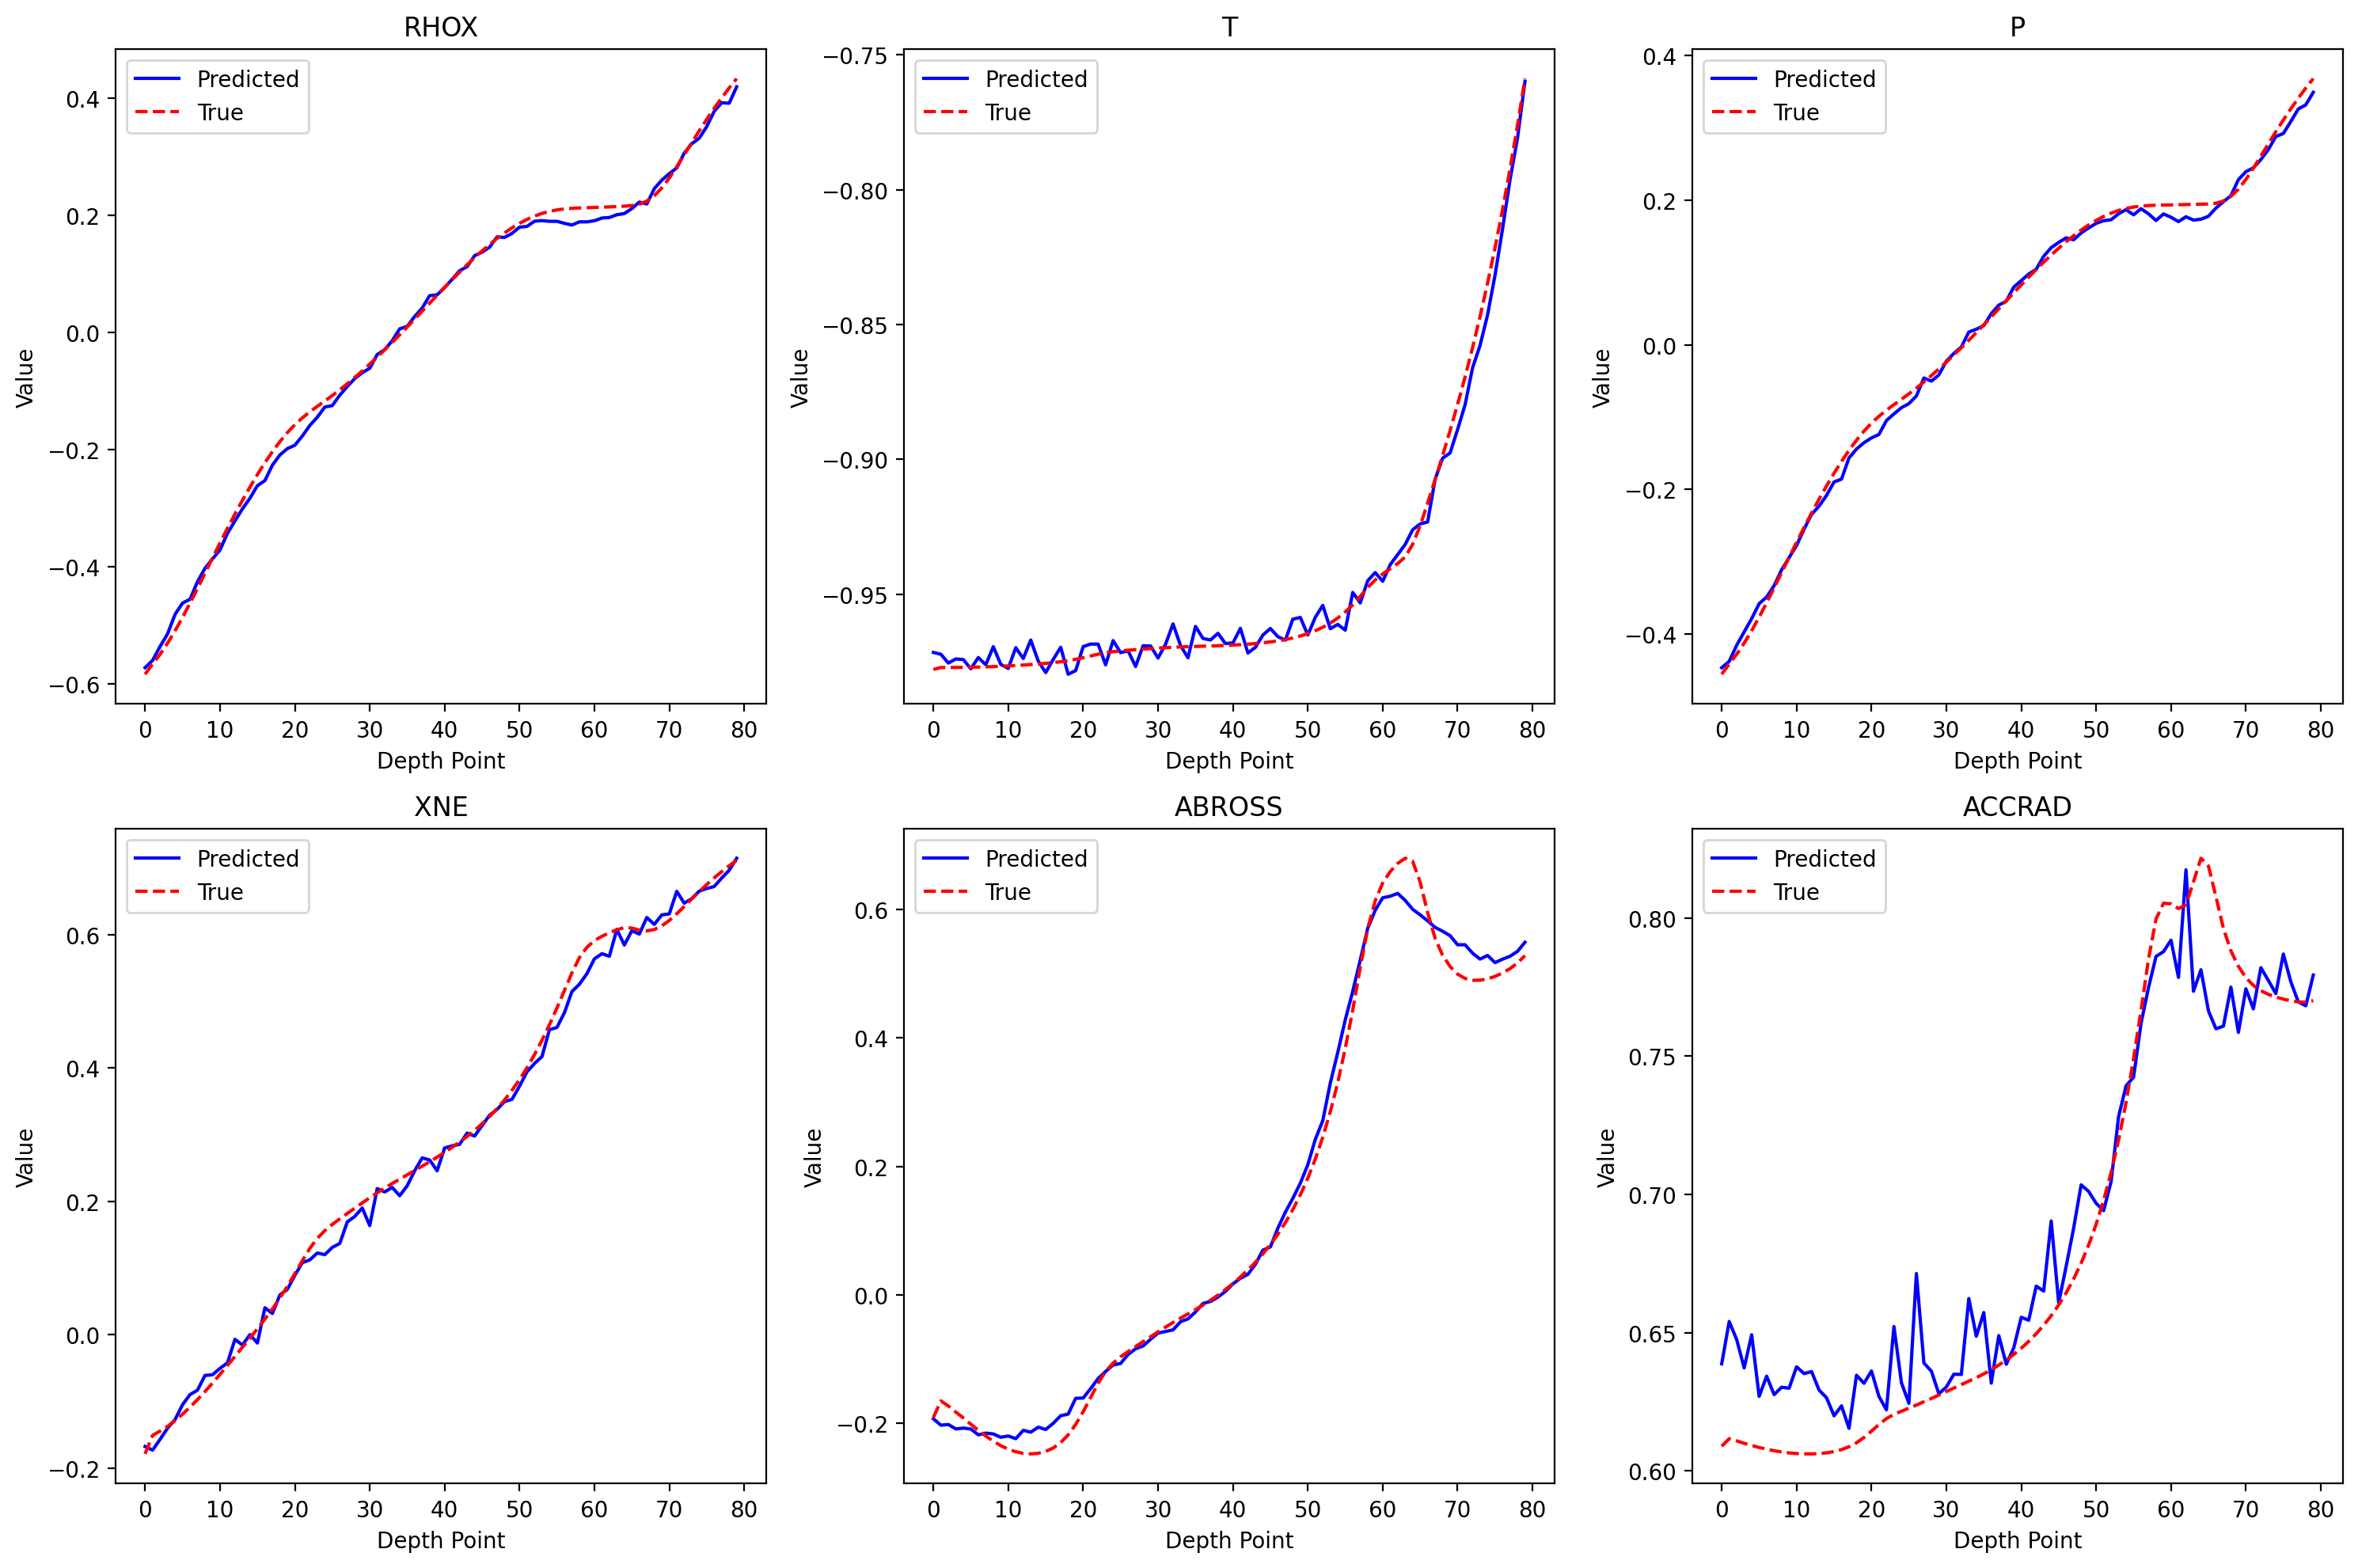

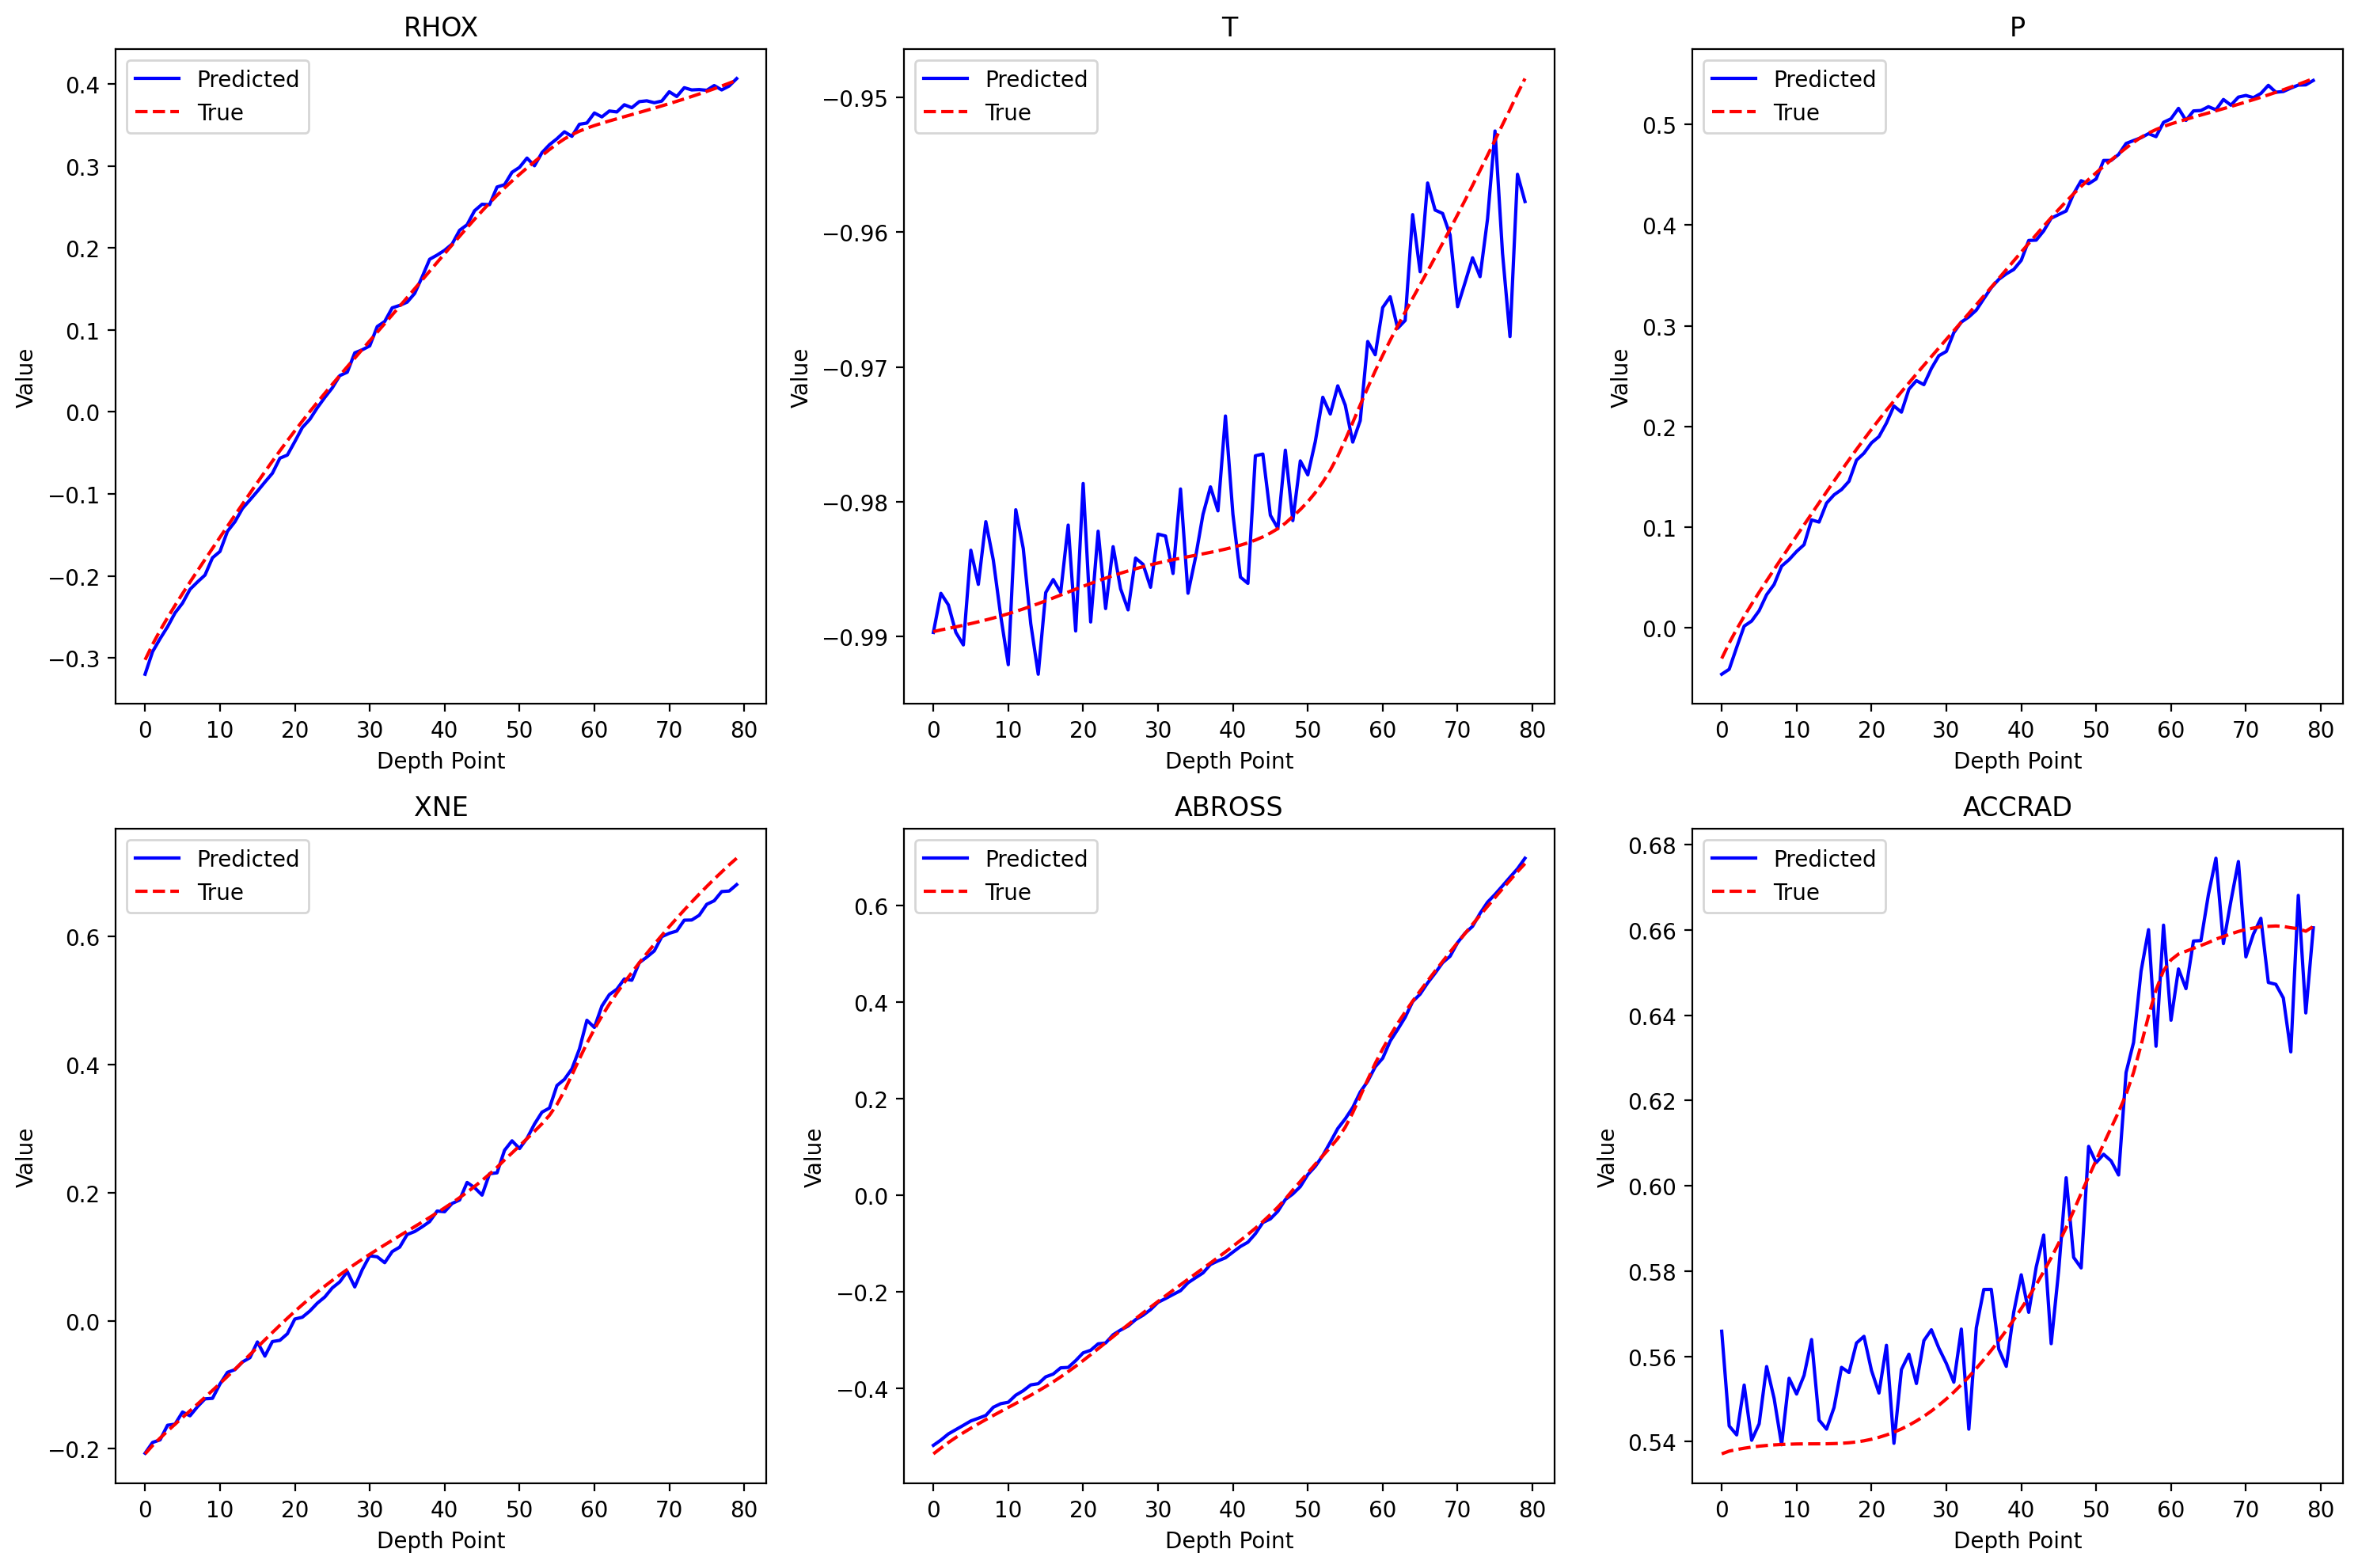

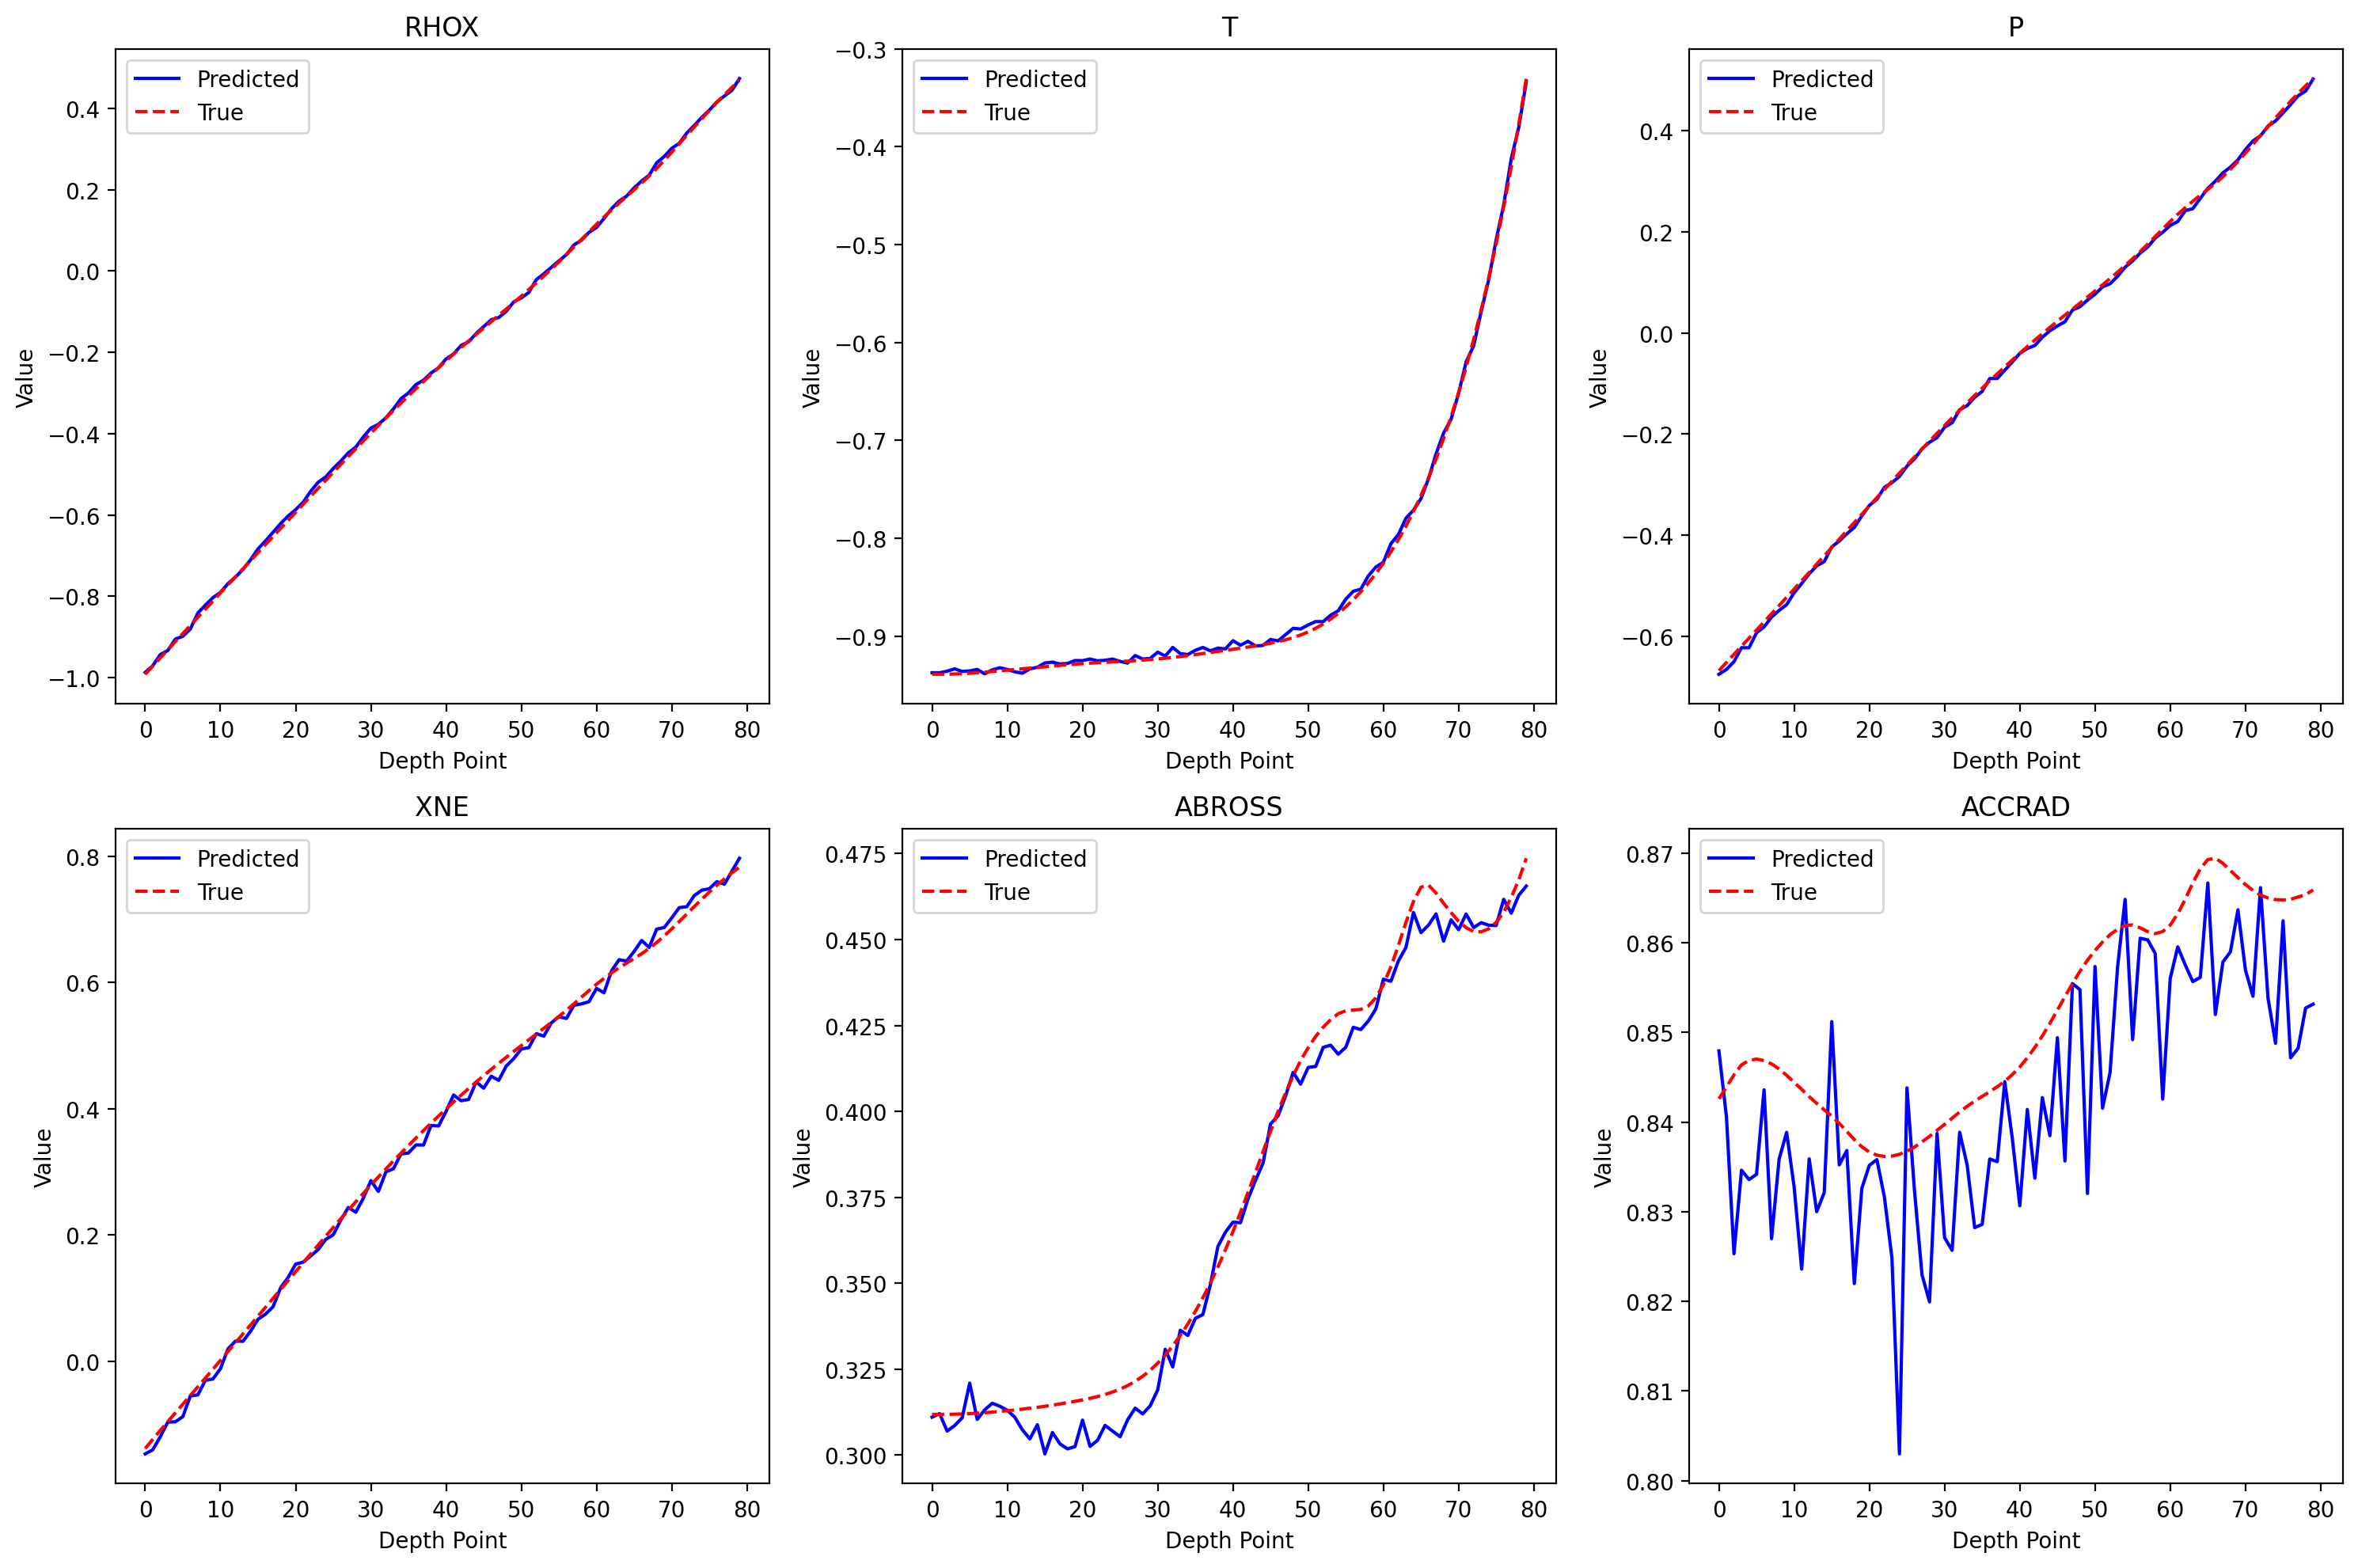

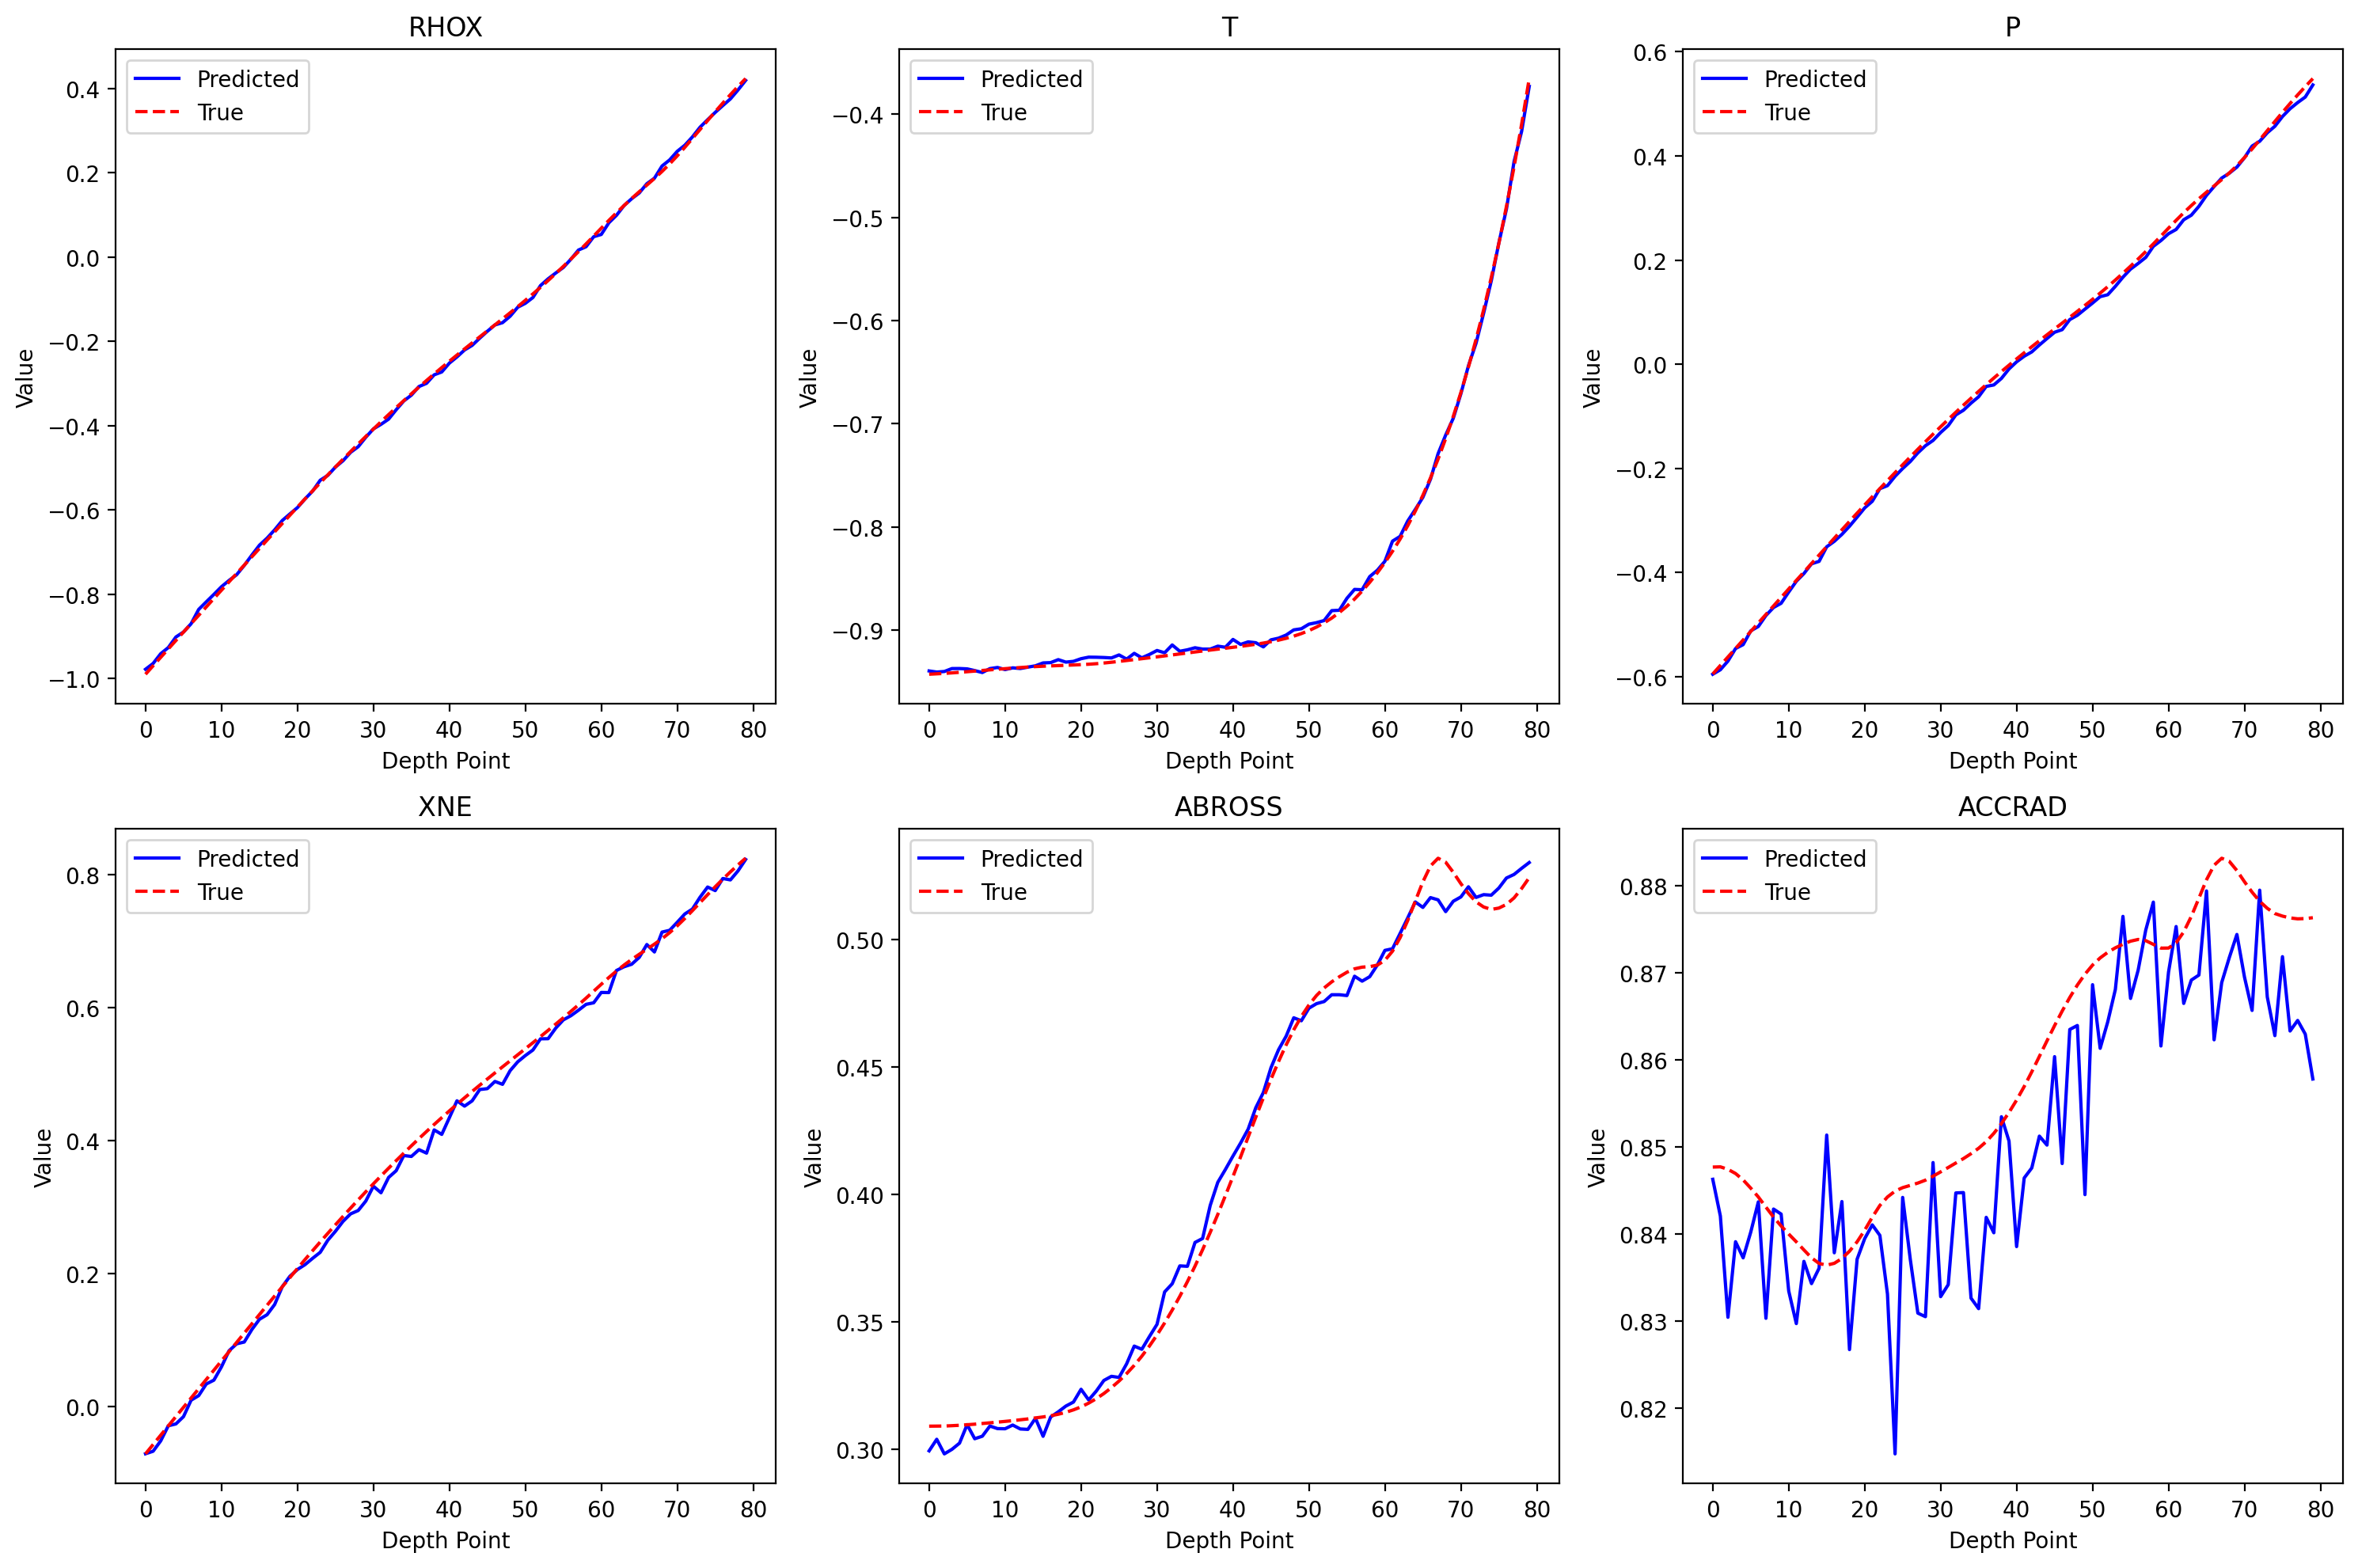

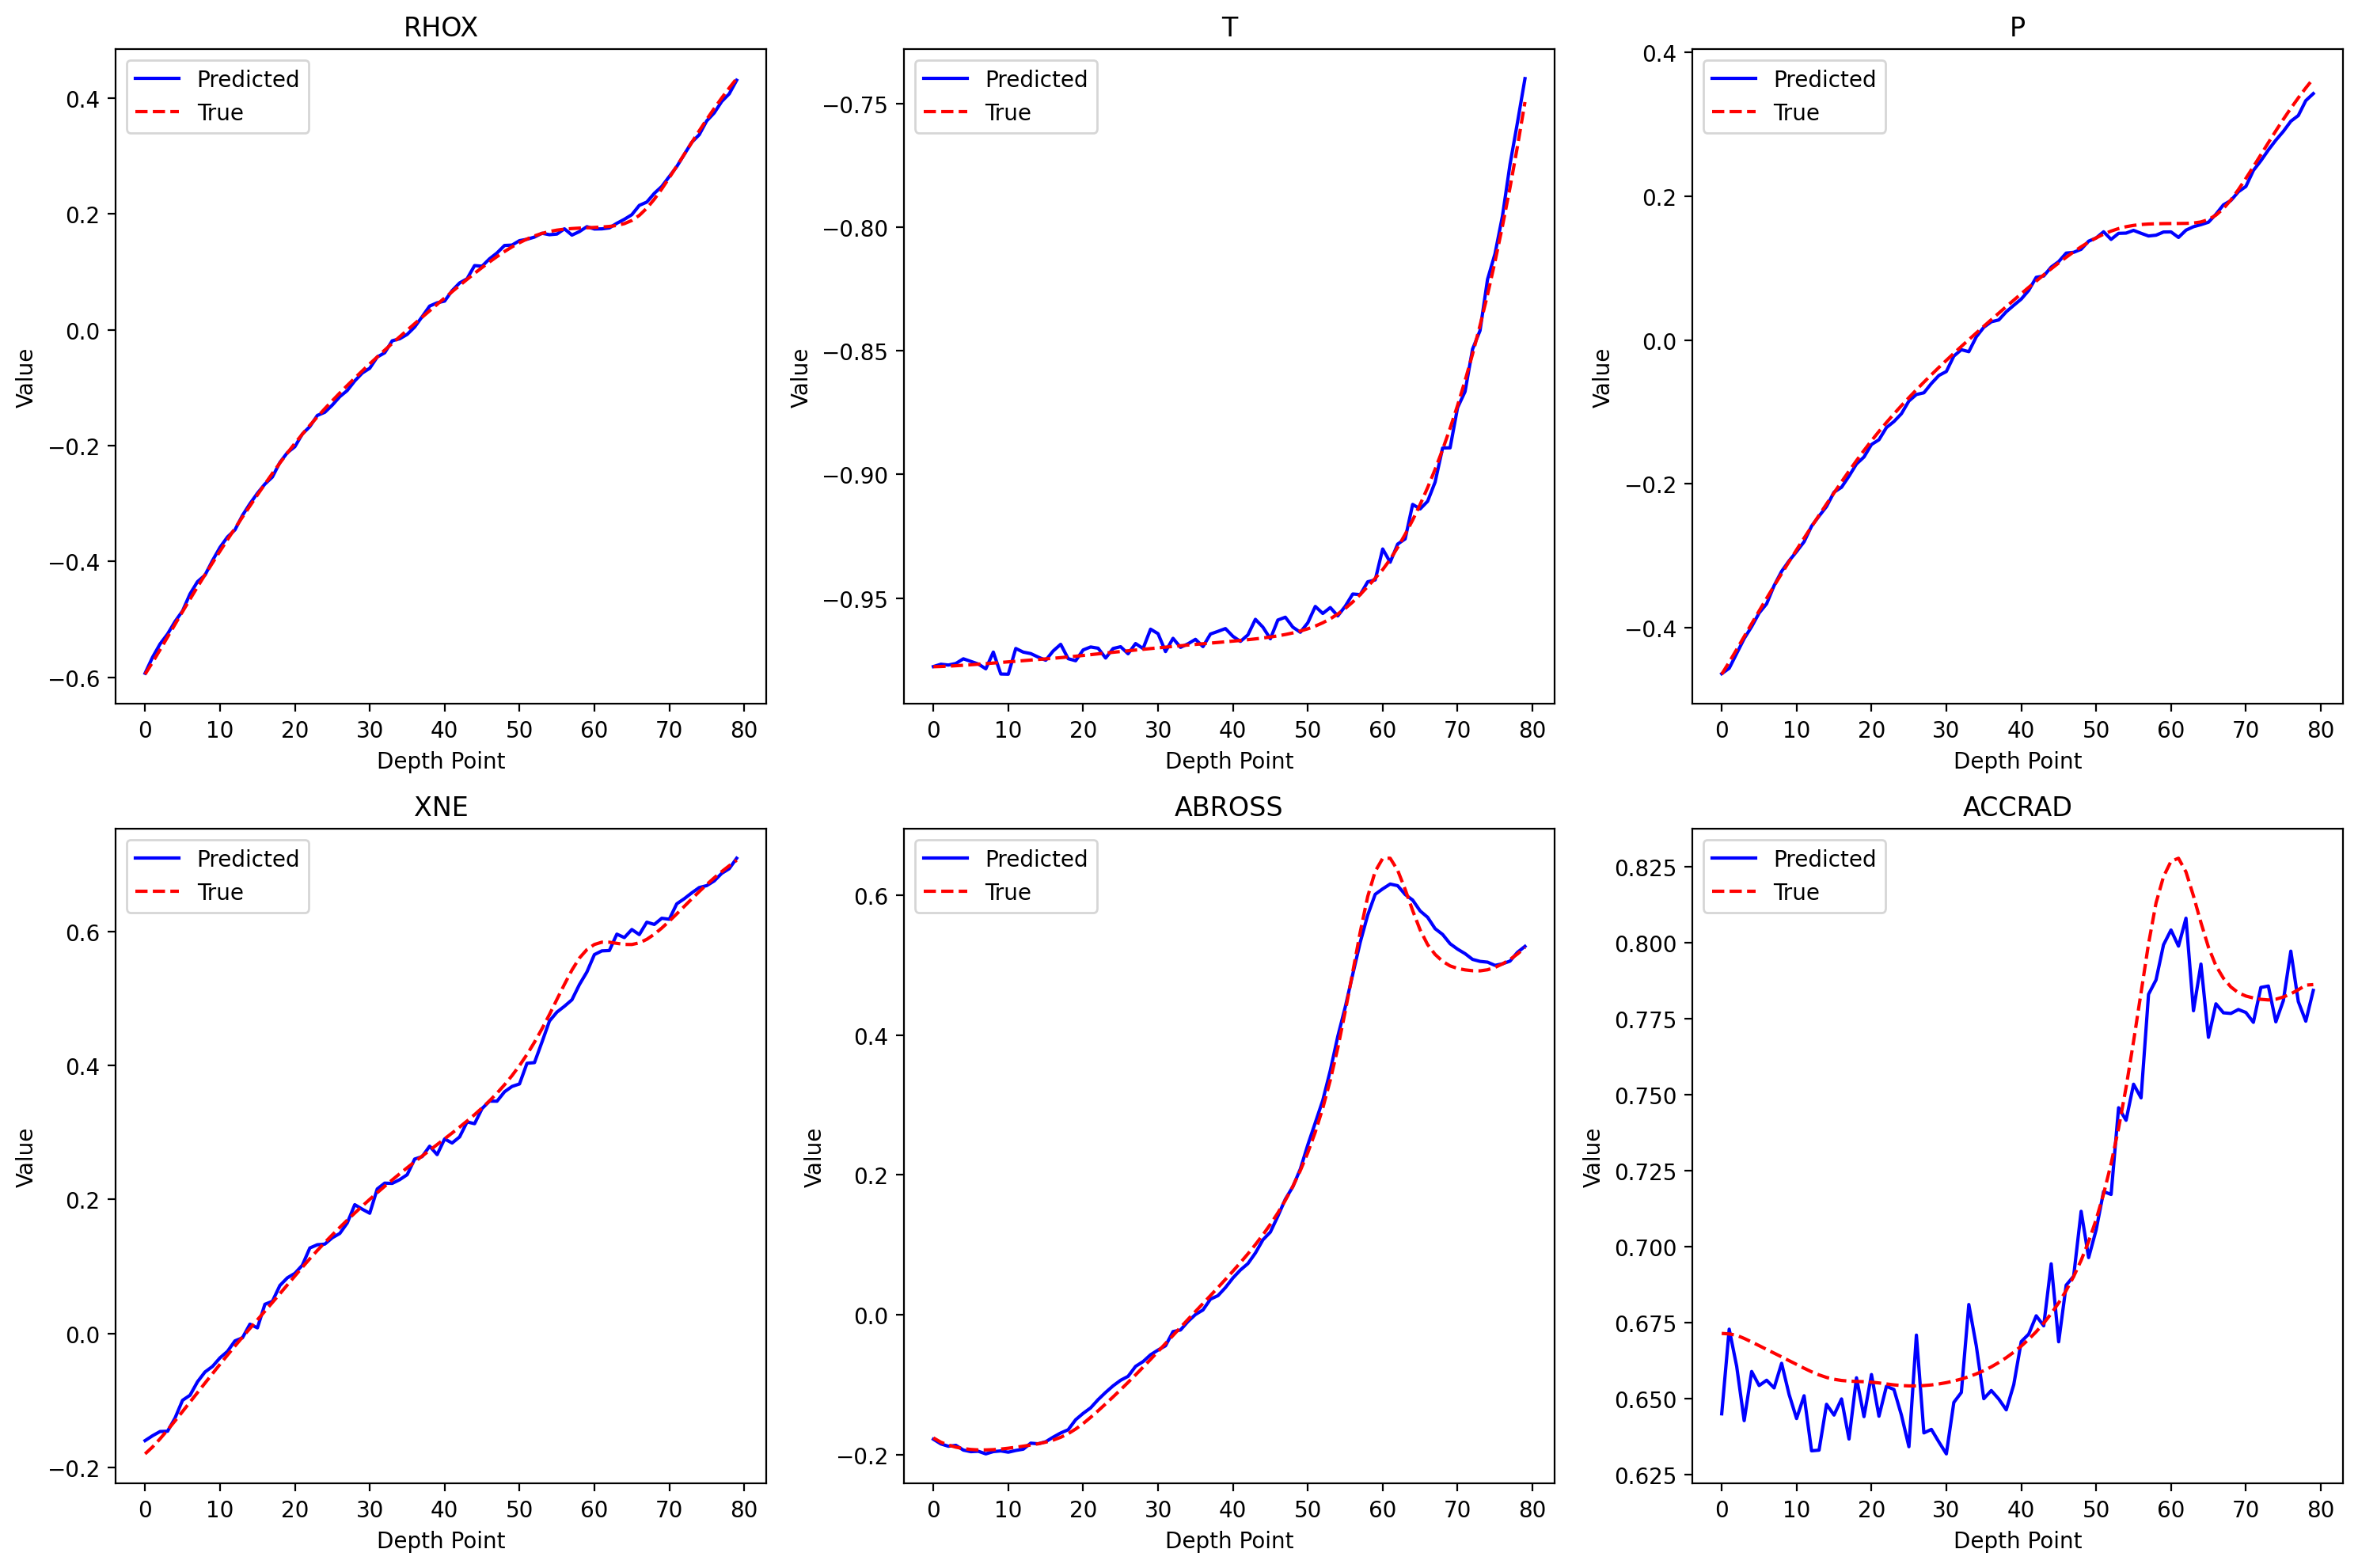

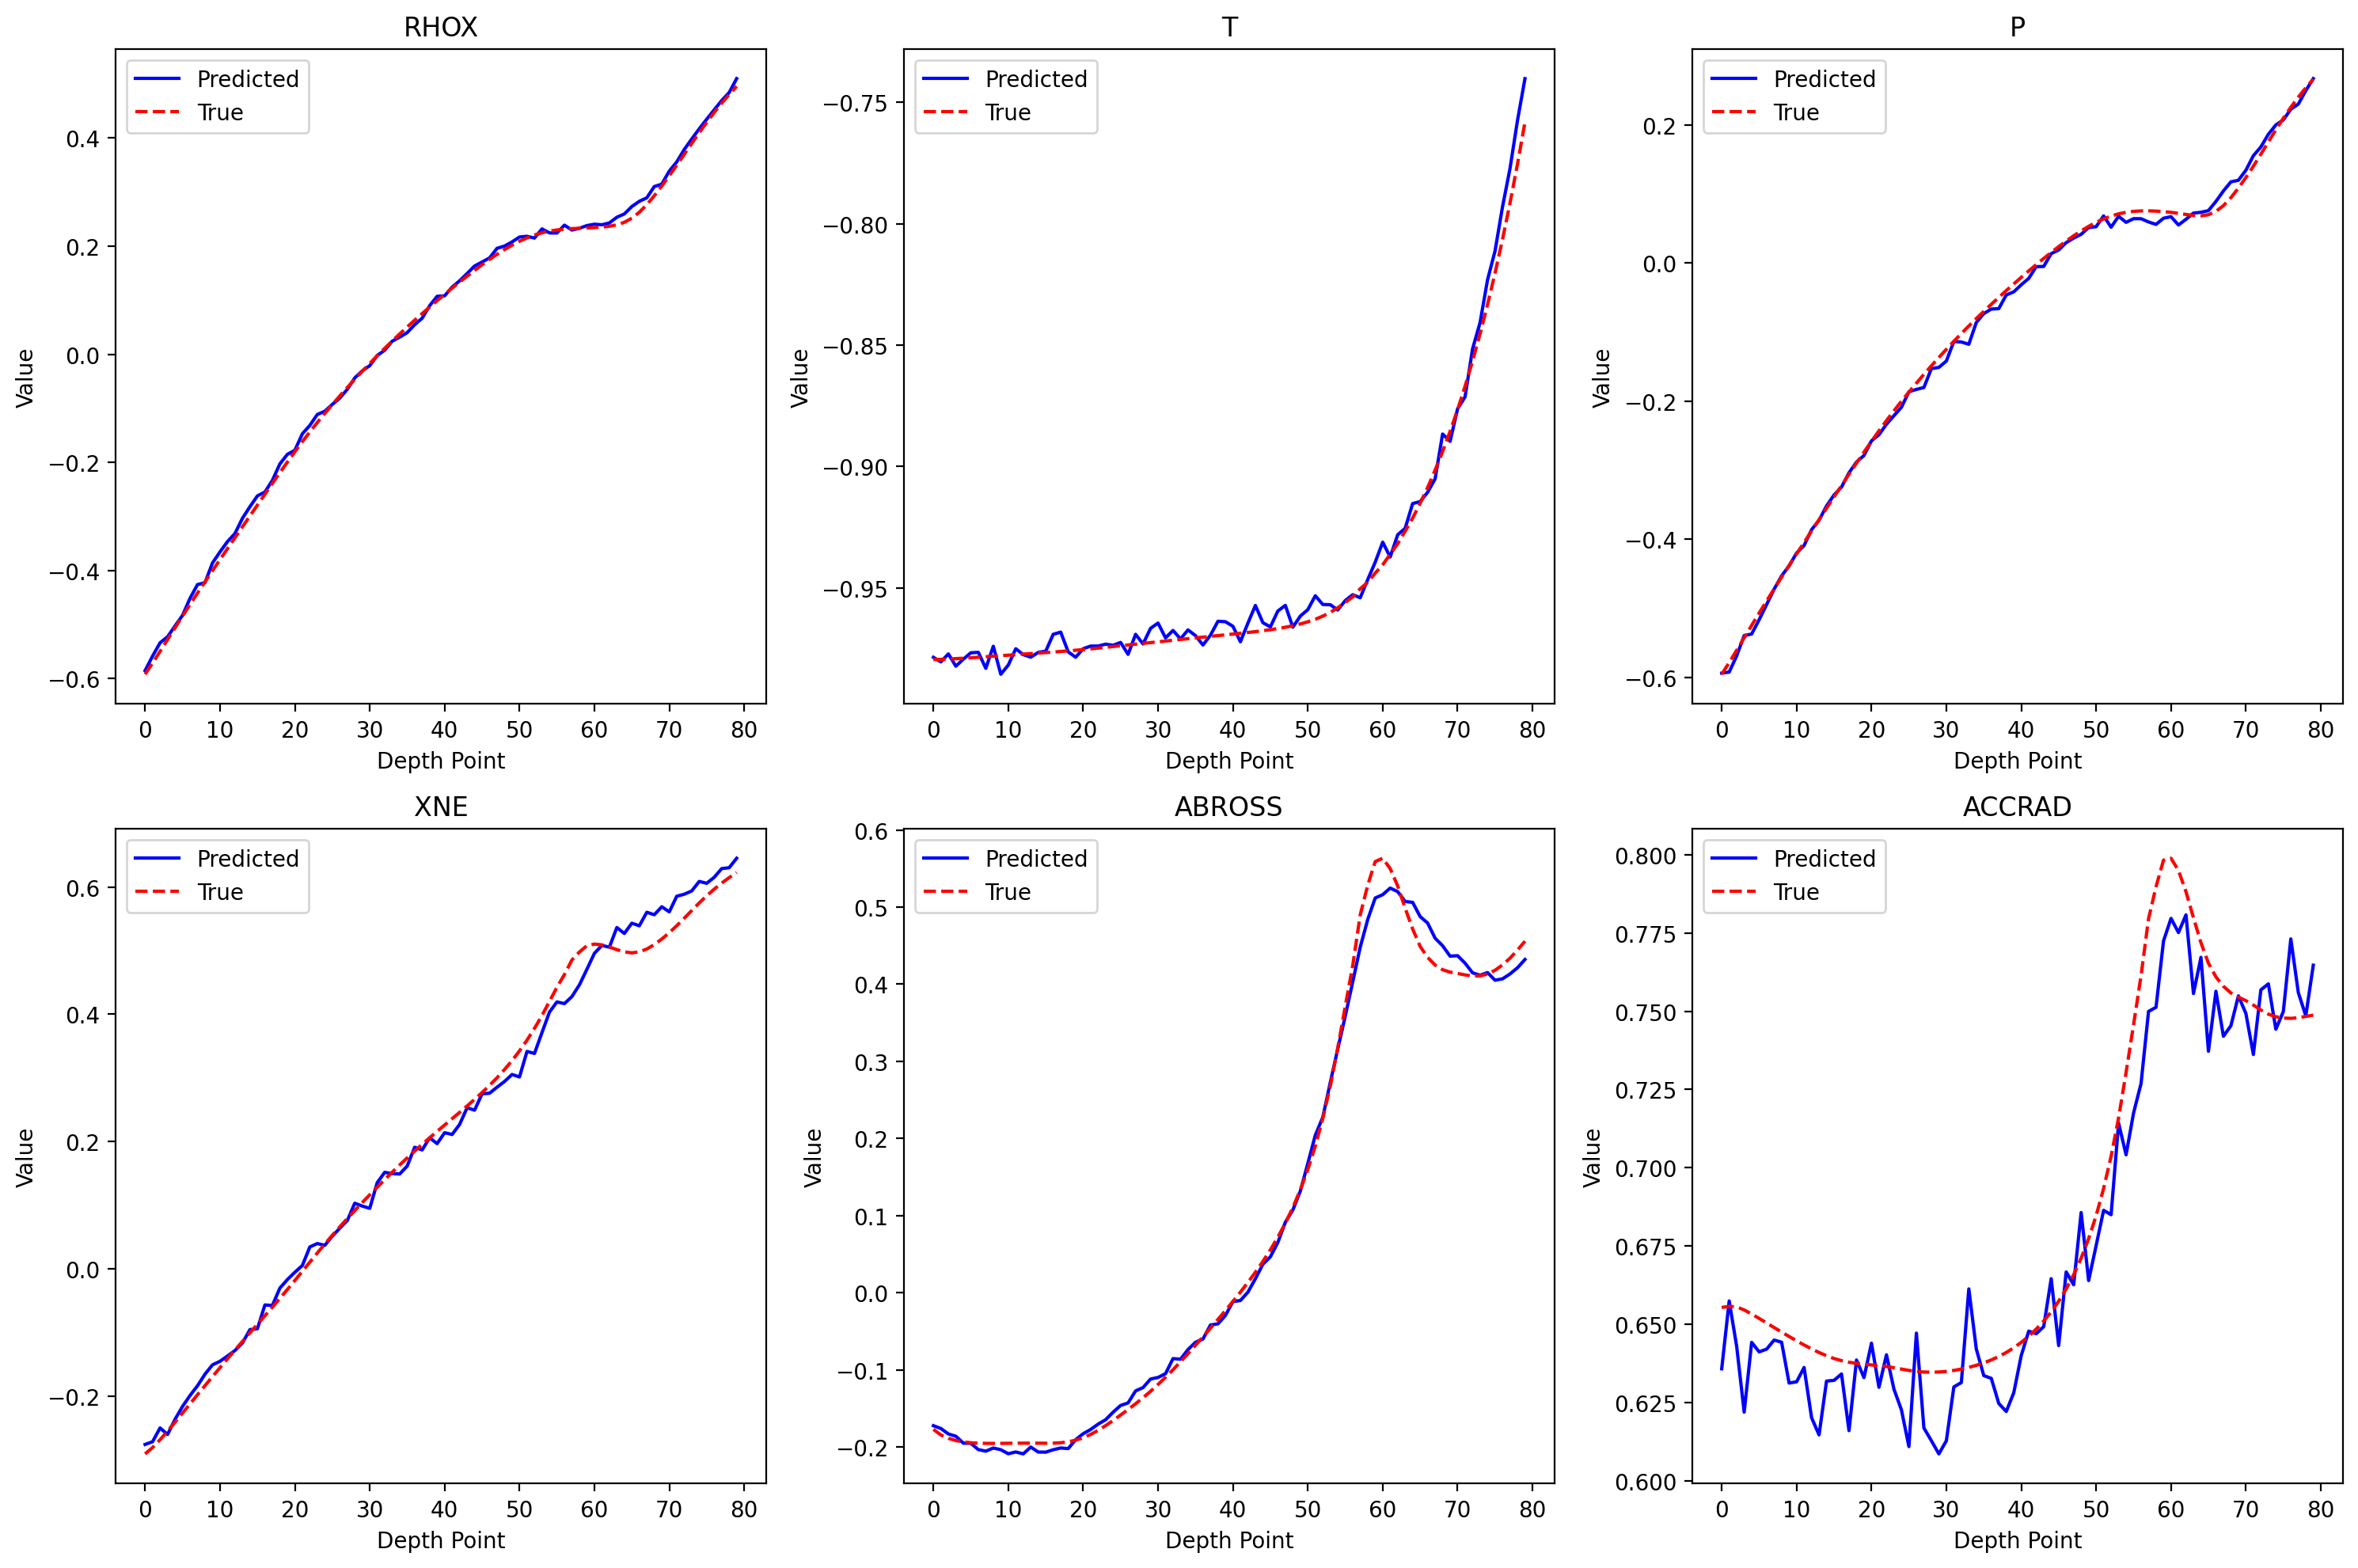

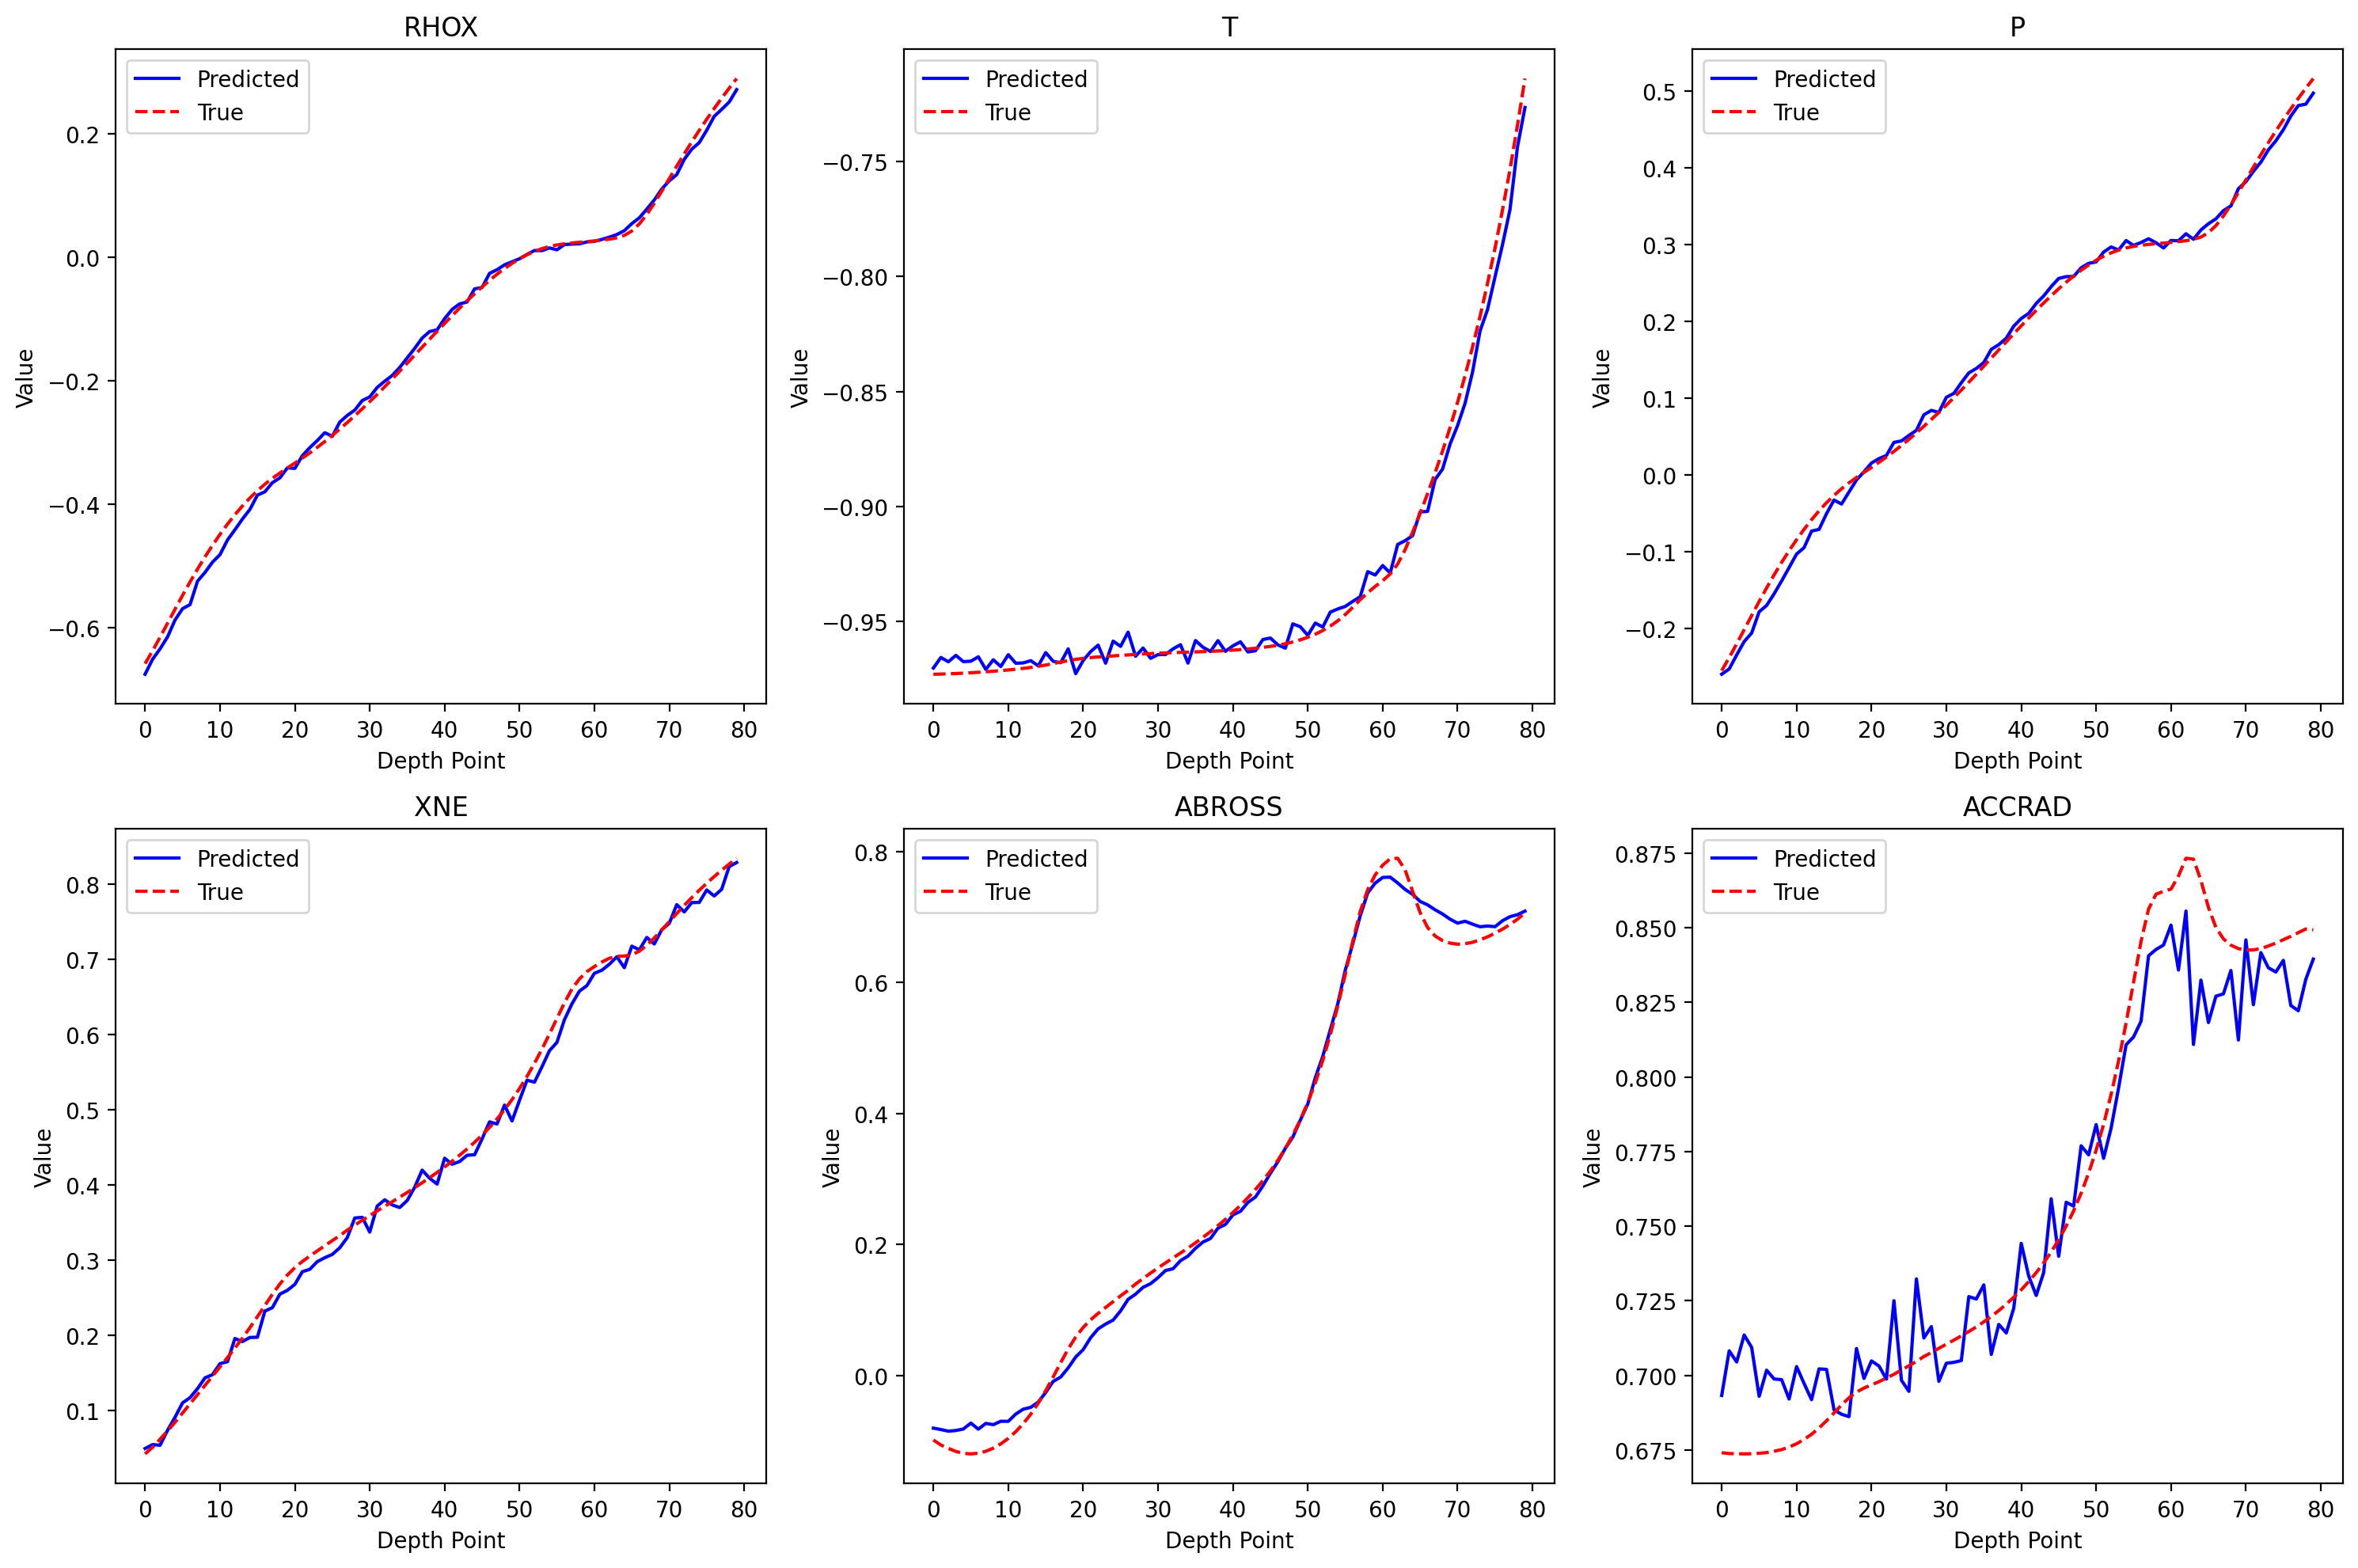

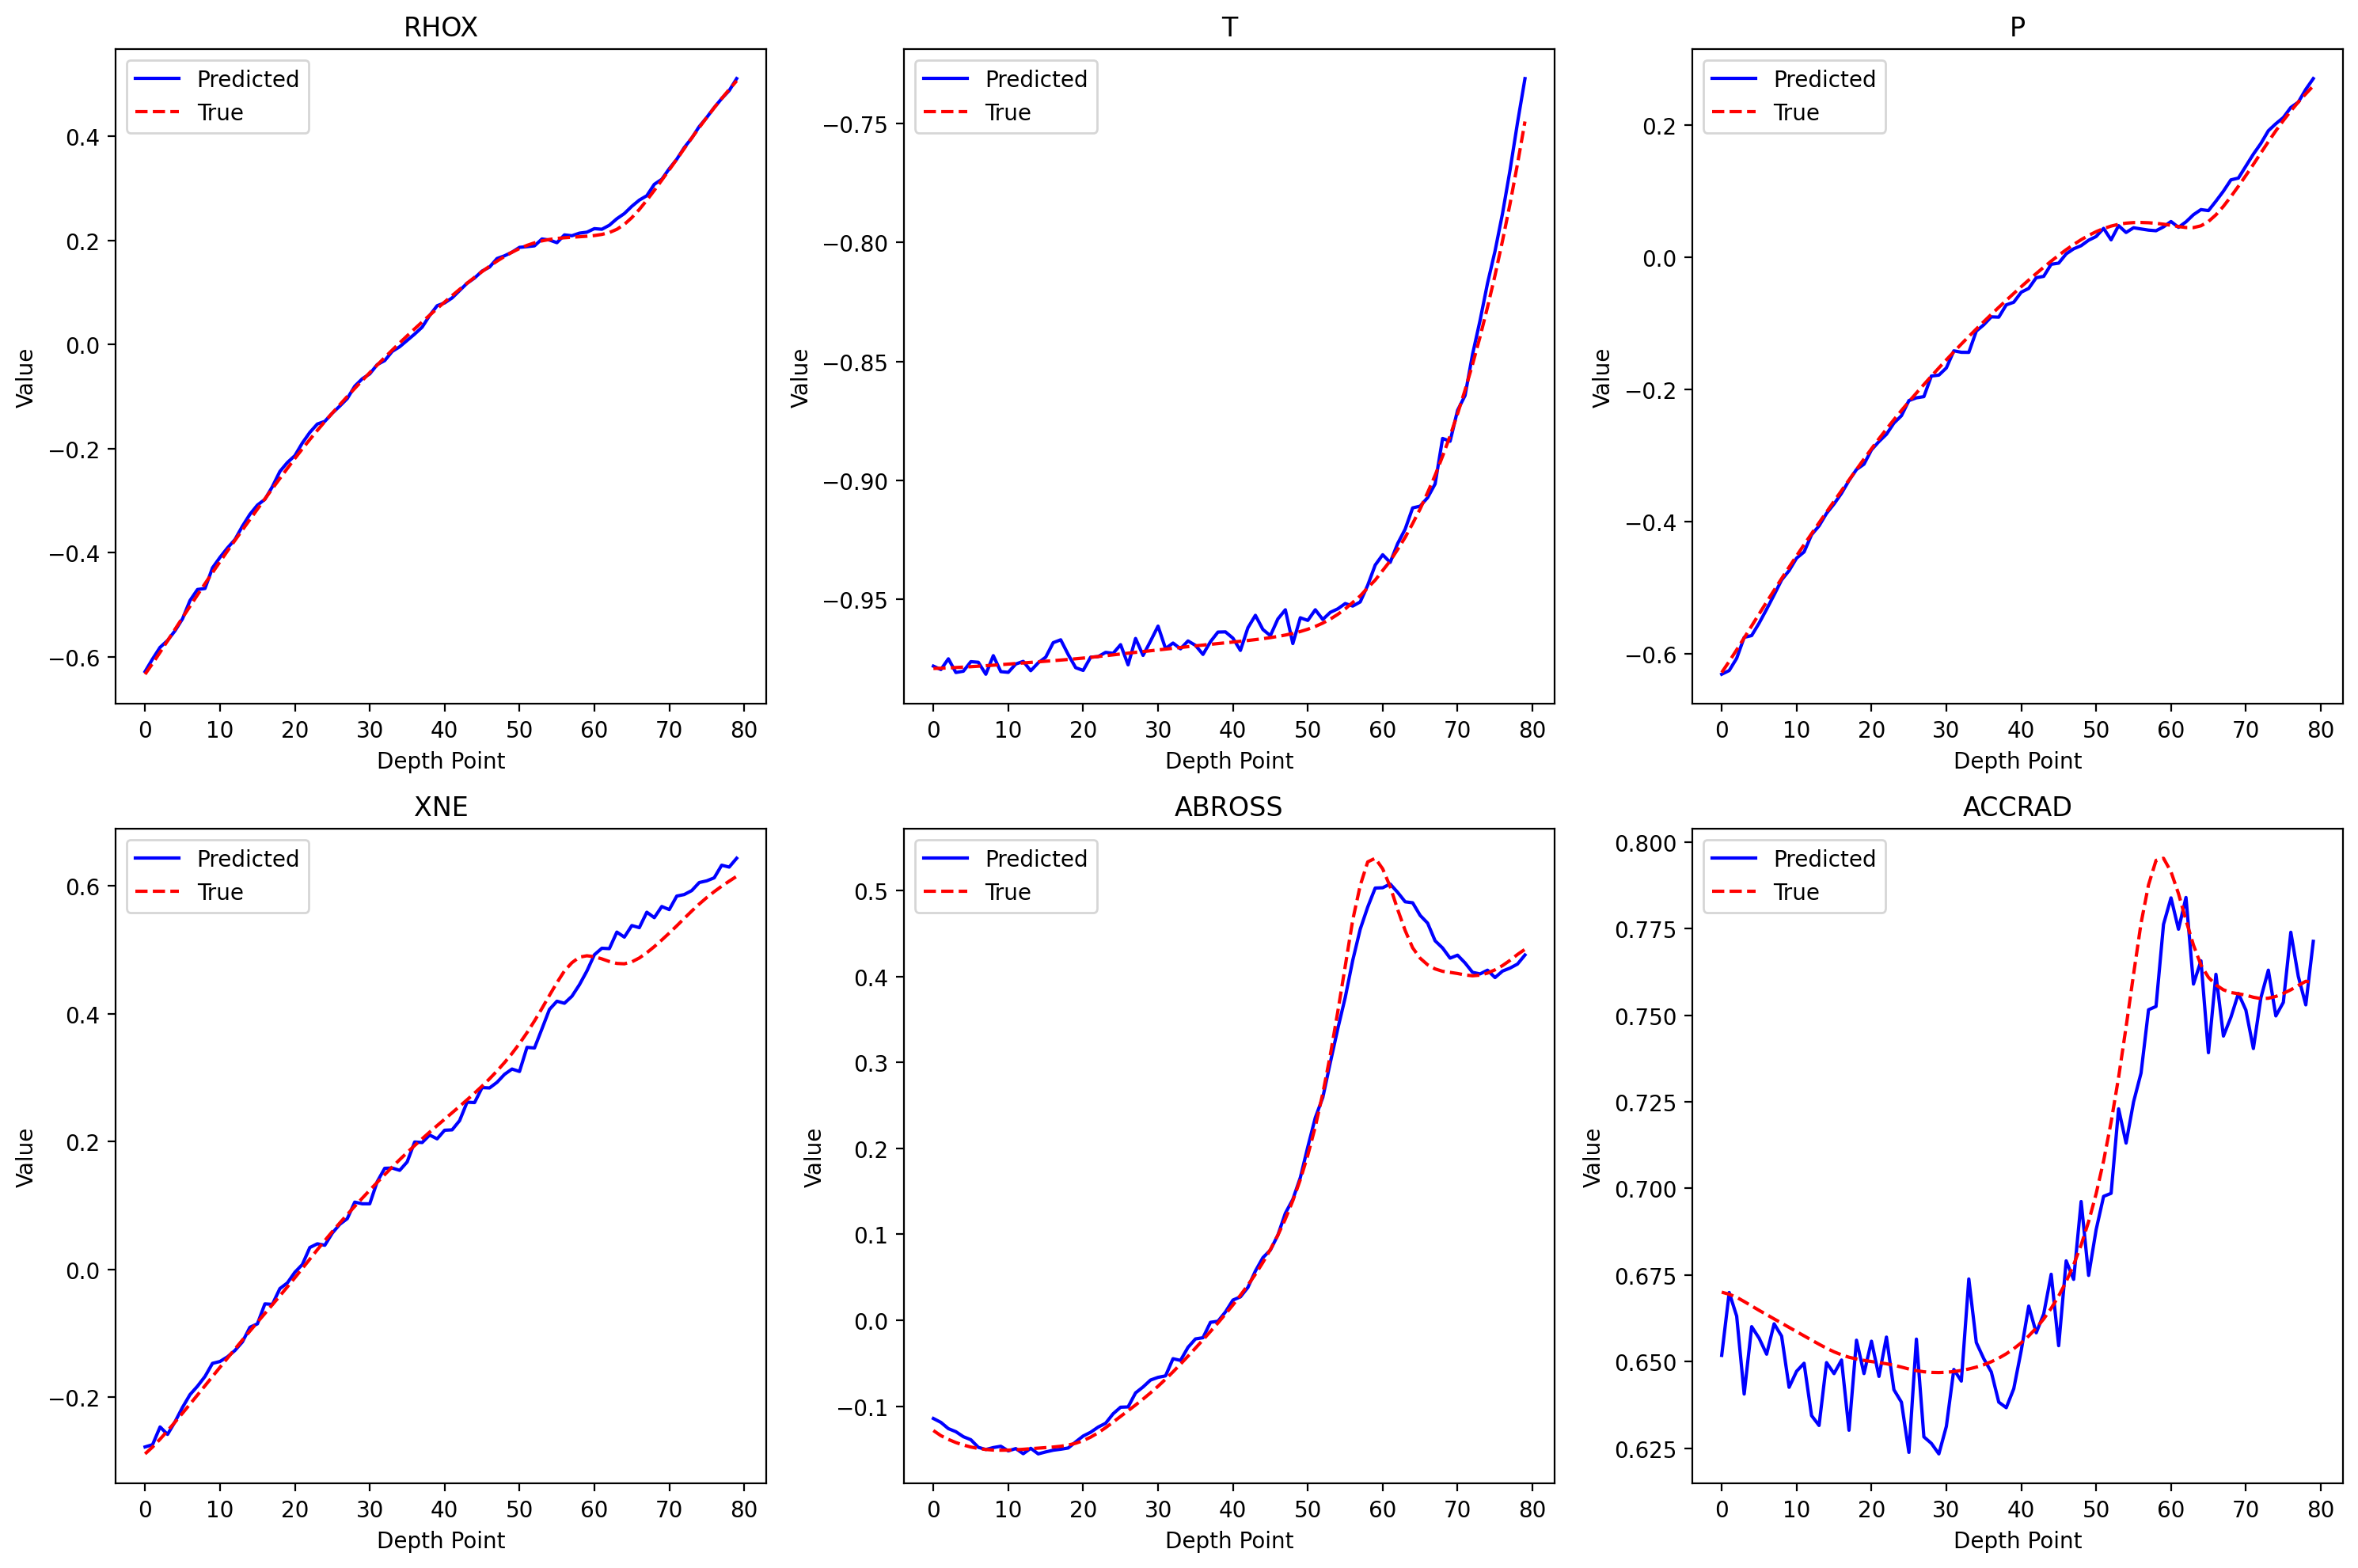

In [3]:
# --- Generate plots ---
# Plot residuals
def plot_residuals(predictions, targets):
    param_names = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD']
    batch_size = predictions.shape[0]
    indices = torch.randperm(batch_size)[:min(5000, batch_size)]
    
    plt.figure(figsize=(15, 10))
    
    for i, param in enumerate(param_names):
        plt.subplot(2, 3, i + 1)
        
        residuals = predictions[indices, :, i] - targets[indices, :, i]
        residuals = residuals.flatten().numpy()
        
        plt.hist(residuals, bins=50, alpha=0.7)
        plt.title(f'{param} Residuals')
        plt.axvline(np.mean(residuals), color='r', linestyle='dashed')
    
    plt.tight_layout()
    return plt

residual_plot = plot_residuals(predictions, targets)

# Plot sample depth profiles
def plot_depth_profile(idx, predictions, targets):
    param_names = ['RHOX', 'T', 'P', 'XNE', 'ABROSS', 'ACCRAD']
    
    plt.figure(figsize=(15, 10))
    for i, param in enumerate(param_names):
        plt.subplot(2, 3, i + 1)
        
        pred_values = predictions[idx, :, i].numpy()
        true_values = targets[idx, :, i].numpy()
        depth_points = np.arange(len(pred_values))
        
        plt.plot(depth_points, pred_values, 'b-', label='Predicted')
        plt.plot(depth_points, true_values, 'r--', label='True')
        
        plt.title(f'{param}')
        plt.xlabel('Depth Point')
        plt.ylabel('Value')
        plt.legend()
    
    plt.tight_layout()
    return plt

# Plot a few sample profiles
sample_indices = torch.randperm(predictions.shape[0])[:10]
for idx in sample_indices:
    profile_plot = plot_depth_profile(idx, predictions, targets)

In [5]:
def calculate_dP_dtau_ground_truth(dataset, sample_indices=None, device='cpu'):
    """
    Calculate the ground truth pressure gradient with respect to optical depth (dP/dtau)
    directly from the dataset.
    Parameters:
        dataset (KuruczDataset): Dataset containing the atmospheric models
        sample_indices (list, optional): Indices of samples to process. If None, use all samples.
        device (str): Device to run calculations on ('cpu' or 'cuda')
        
    Returns:
        dict: Dictionary containing tau and dP/dtau values for each sample
    """
    if sample_indices is None:
        sample_indices = range(len(dataset))
    
    results = {
        'tau': [],
        'dP_dtau': [],
        'g_kappa': [],
        'teff': [],
        'gravity': [],
        'feh': [],
        'afe': []
    }
    
    for idx in sample_indices:
        # Get data from dataset
        # p_normalized = dataset.P[idx]
        abross_normalized = dataset.ABROSS[idx]
        
        # Use original tau values directly (recommended approach based on code comments)
        tau = dataset.original['TAU'][idx].cpu().numpy()
        
        # Denormalize other parameters
        # pressure = dataset.denormalize('P', p_normalized).cpu().numpy()
        pressure = dataset.original['P'][idx].cpu().numpy()
        kappa = dataset.denormalize('ABROSS', abross_normalized).cpu().numpy()
        
        # Calculate dP/dtau
        dP_dtau = calculate_gradient_torch(
            torch.tensor(tau).unsqueeze(0), 
            torch.tensor(pressure).unsqueeze(0)
        )[0].numpy()
        
        # Get stellar parameters
        teff = dataset.denormalize('teff', dataset.teff[idx]).item()
        gravity = 10**dataset.denormalize('gravity', dataset.gravity[idx]).item()
        feh = dataset.denormalize('feh', dataset.feh[idx]).item()
        afe = dataset.denormalize('afe', dataset.afe[idx]).item()
        
        # Calculate g/kappa
        g_kappa = gravity / kappa
        
        # Store results
        results['tau'].append(tau)
        results['dP_dtau'].append(dP_dtau)
        results['g_kappa'].append(g_kappa)
        results['teff'].append(teff)
        results['gravity'].append(gravity)
        results['feh'].append(feh)
        results['afe'].append(afe)
    
    return results

def calculate_dP_dtau_predicted(model, dataset, sample_indices=None, device='cpu'):
    """
    Calculate the predicted pressure gradient with respect to optical depth (dP/dtau)
    and g/kappa using the model predictions.
    
    Parameters:
        model (AtmosphereNet): Trained neural network model
        dataset (KuruczDataset): Dataset containing the atmospheric models
        sample_indices (list, optional): Indices of samples to process. If None, use all samples.
        device (str): Device to run calculations on ('cpu' or 'cuda')
        
    Returns:
        dict: Dictionary containing tau, predicted dP/dtau, and g/kappa values for each sample
    """
    if sample_indices is None:
        sample_indices = range(len(dataset))
    
    results = {
        'tau': [],
        'dP_dtau_pred': [],
        'g_kappa_pred': [],
        'teff': [],
        'gravity': [],
        'feh': [],
        'afe': []
    }
    
    model.eval()
    with torch.no_grad():
        for idx in sample_indices:
            # Get model prediction
            outputs = model(dataset[idx][0].unsqueeze(0))
            
            # Extract predicted values
            p_pred_norm = outputs[0, :, 2].cpu()
            abross_pred_norm = outputs[0, :, 4].cpu()
            
            # Use original tau values directly
            tau = dataset.original['TAU'][idx].cpu().numpy()
            
            # Denormalize predicted values
            pressure_pred = dataset.denormalize('P', p_pred_norm).cpu().numpy()
            abross_pred = dataset.denormalize('ABROSS', abross_pred_norm).cpu().numpy()
            
            # Calculate predicted dP/dtau
            dP_dtau_pred = calculate_gradient_torch(
                torch.tensor(tau).unsqueeze(0), 
                torch.tensor(pressure_pred).unsqueeze(0)
            )[0].numpy()
            
            # Get stellar parameters
            teff = dataset.denormalize('teff', dataset.teff[idx]).item()
            gravity = dataset.denormalize('gravity', dataset.gravity[idx]).item()
            feh = dataset.denormalize('feh', dataset.feh[idx]).item()
            afe = dataset.denormalize('afe', dataset.afe[idx]).item()
            
            # Calculate predicted g/kappa
            g_kappa_pred = 10**gravity / abross_pred
            
            # Store results
            results['tau'].append(tau)
            results['dP_dtau_pred'].append(dP_dtau_pred)
            results['g_kappa_pred'].append(g_kappa_pred)
            results['teff'].append(teff)
            results['gravity'].append(gravity)
            results['feh'].append(feh)
            results['afe'].append(afe)
    
    return results
# Example usage:
dP_dtau_ground_truth = calculate_dP_dtau_ground_truth(dataset, sample_indices=sample_indices)
dP_dtau_predicted = calculate_dP_dtau_predicted(model, dataset, sample_indices=sample_indices, device=device)

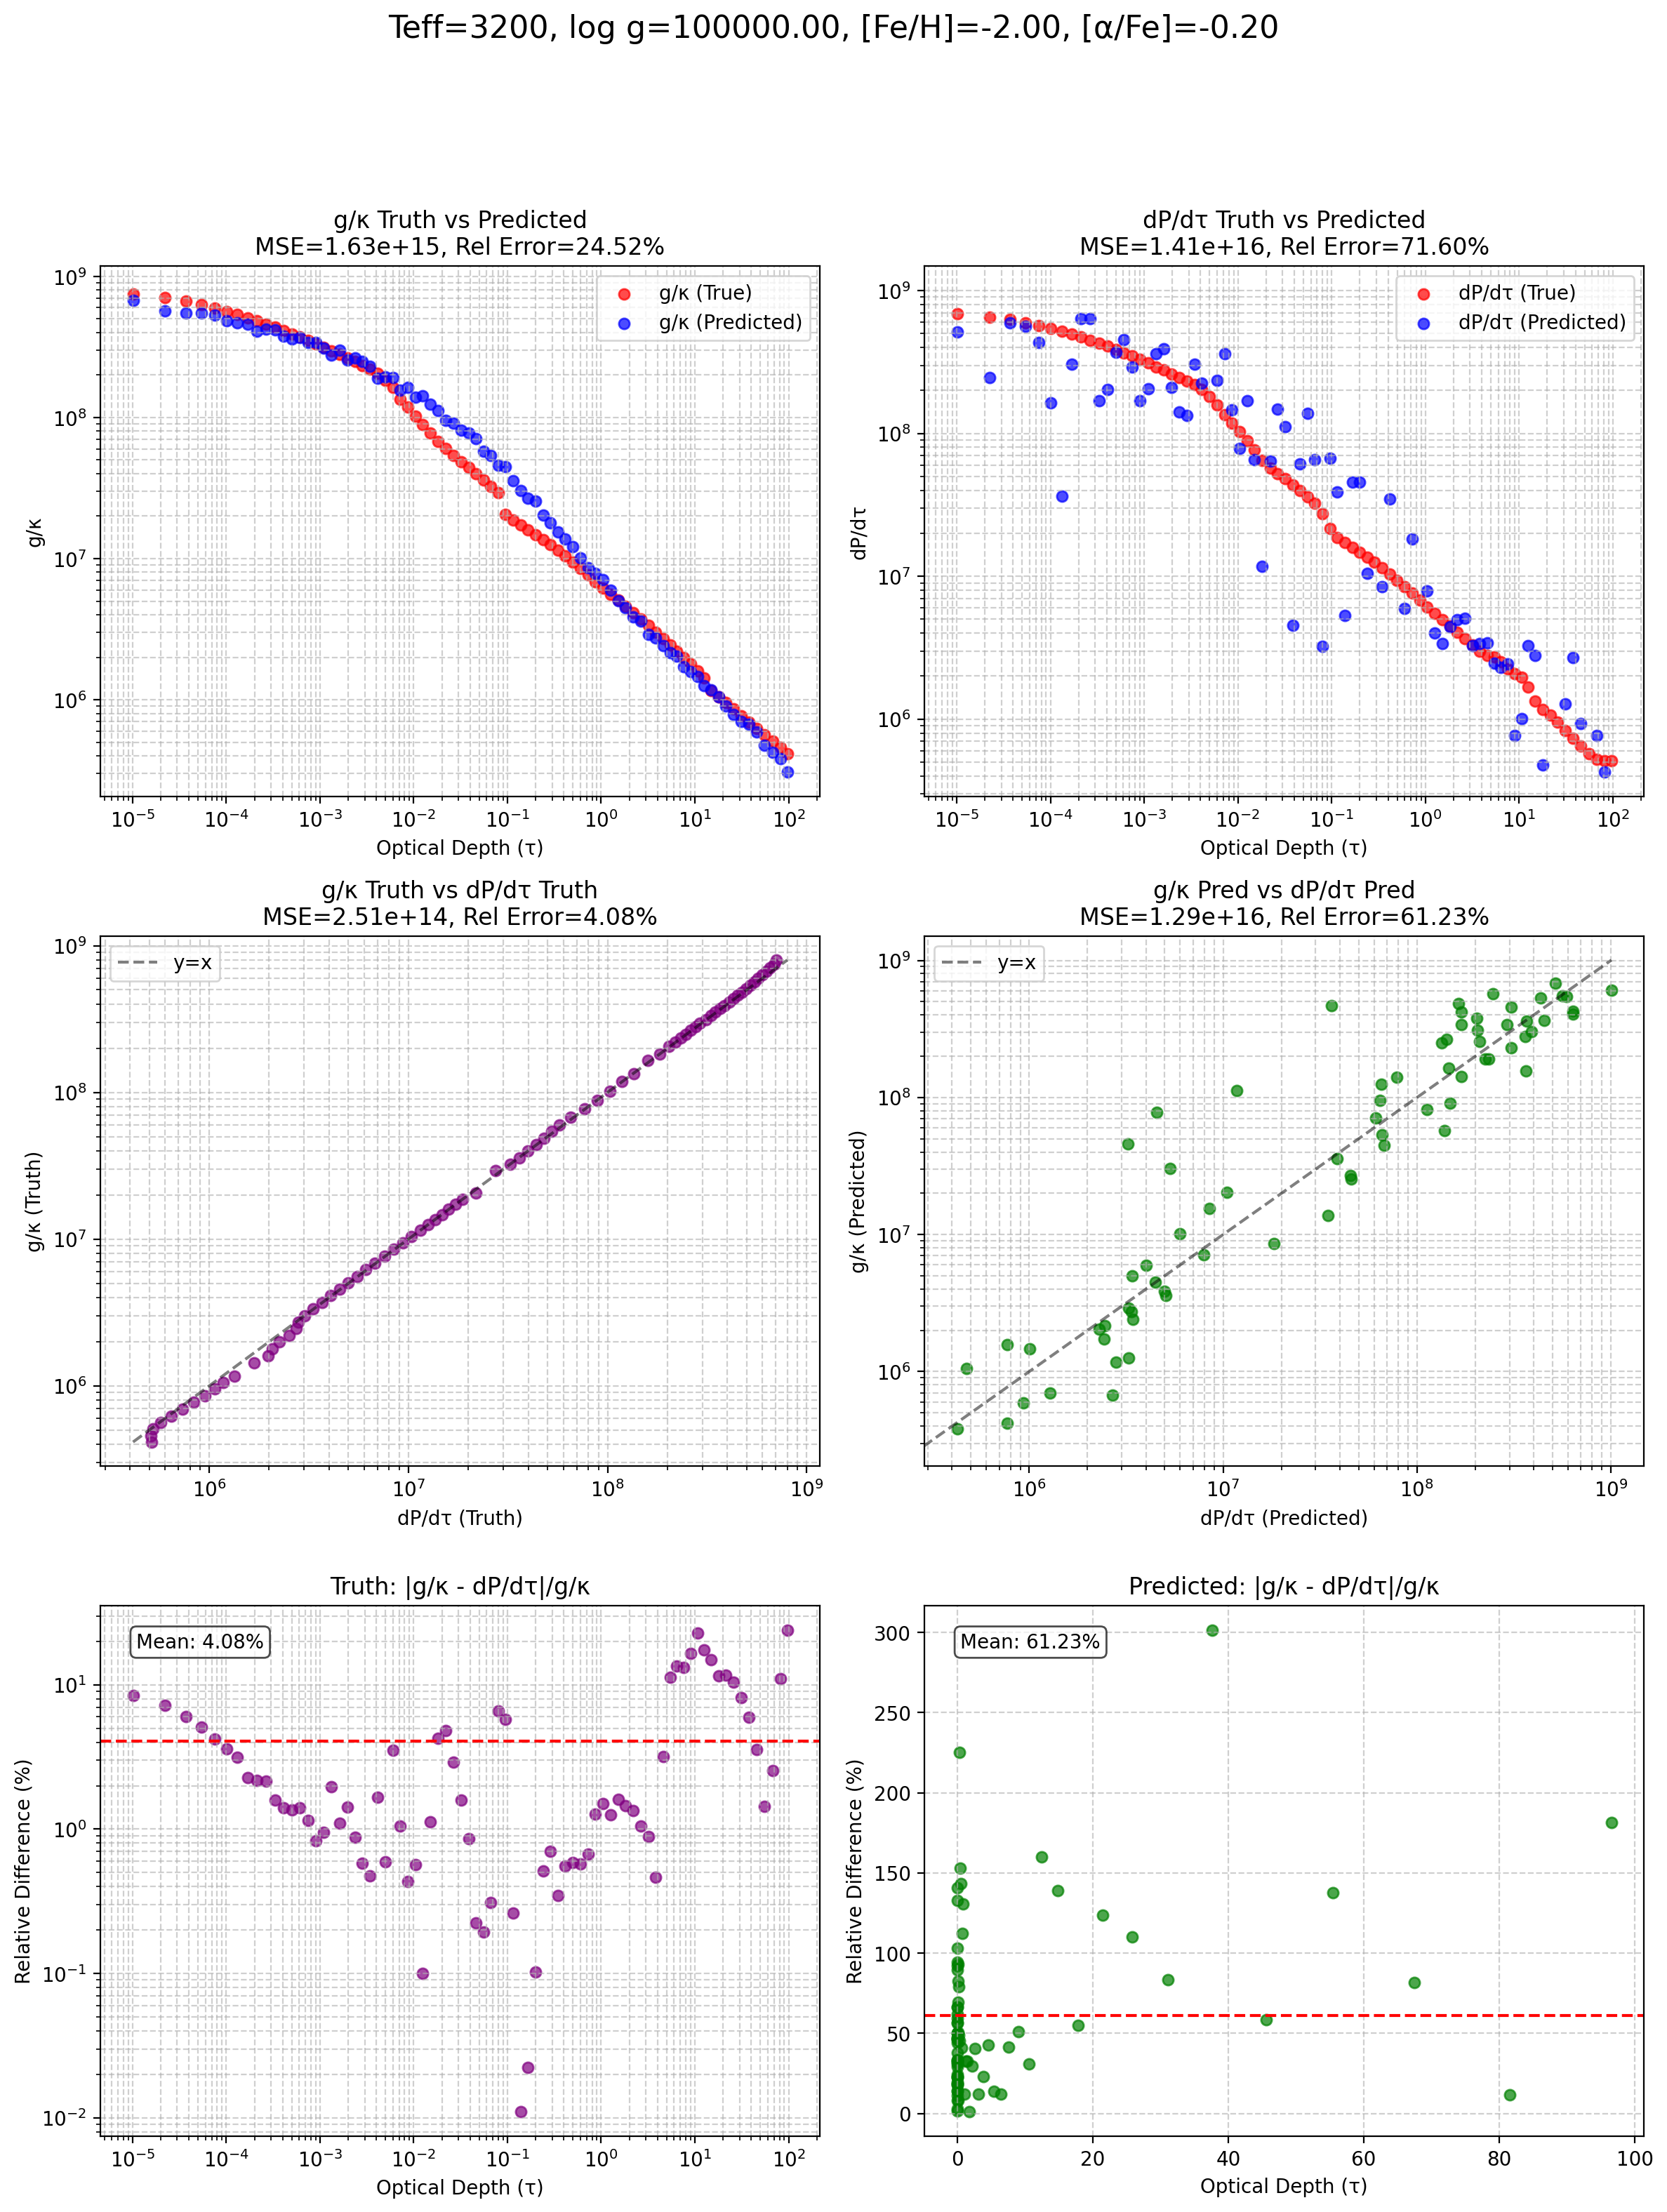

In [ ]:
def plot_comprehensive_comparison(dP_dtau_predicted, dP_dtau_ground_truth, sample_idx=0):
    """
    Create a 2x2 grid of plots for a single sample showing:
    1. g/kappa truth vs g/kappa predicted
    2. dP/dtau truth vs dP/dtau predicted
    3. g/kappa truth vs dP/dtau truth
    4. g/kappa predicted vs dP/dtau predicted
    
    Parameters:
        results_diff_grad (dict): Results from differential gradient calculation
        dP_dtau_ground_truth (dict): Ground truth dP/dtau values
        sample_idx (int): Index of the sample to plot
        
    Returns:
        matplotlib.figure.Figure: The generated figure
    """
    # Create a 2x2 grid
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))
    
    # Get data for the specified sample
    
    # Get data for the specified sample
    tau = dP_dtau_predicted['tau'][sample_idx]
    dP_dtau_pred = dP_dtau_predicted['dP_dtau_pred'][sample_idx]
    g_kappa_pred = dP_dtau_predicted['g_kappa_pred'][sample_idx]
    g_kappa_true = dP_dtau_ground_truth['g_kappa'][sample_idx]
    
    # Get ground truth dP/dtau
    tau_gt = dP_dtau_ground_truth['tau'][sample_idx]
    dP_dtau_true = dP_dtau_ground_truth['dP_dtau'][sample_idx]
    
    # 过滤NaN和Inf值
    valid_tau = ~np.isnan(tau) & ~np.isinf(tau)
    valid_gk_true = ~np.isnan(g_kappa_true) & ~np.isinf(g_kappa_true)
    valid_gk_pred = ~np.isnan(g_kappa_pred) & ~np.isinf(g_kappa_pred)
    valid_dp_pred = ~np.isnan(dP_dtau_pred) & ~np.isinf(dP_dtau_pred)
    valid_tau_gt = ~np.isnan(tau_gt) & ~np.isinf(tau_gt)
    valid_dp_true = ~np.isnan(dP_dtau_true) & ~np.isinf(dP_dtau_true)
    
    # 组合掩码
    valid_plot1_true = valid_tau & valid_gk_true
    valid_plot1_pred = valid_tau & valid_gk_pred
    valid_plot2_true = valid_tau_gt & valid_dp_true
    valid_plot2_pred = valid_tau & valid_dp_pred

    axes[0, 0].scatter(tau[valid_plot1_true], g_kappa_true[valid_plot1_true], s=30, label='g/κ (True)', color='red', alpha=0.7)
    axes[0, 0].scatter(tau[valid_plot1_pred], g_kappa_pred[valid_plot1_pred], s=30, label='g/κ (Predicted)', color='blue', alpha=0.7)
    
    # Plot 2: dP/dtau truth vs dP/dtau predicted
    valid_plot2_true = valid_tau_gt & valid_dp_true
    valid_plot2_pred = valid_tau & valid_dp_pred
    axes[0, 1].scatter(tau_gt[valid_plot2_true], dP_dtau_true[valid_plot2_true], s=30, label='dP/dτ (True)', color='red', alpha=0.7)
    axes[0, 1].scatter(tau[valid_plot2_pred], dP_dtau_pred[valid_plot2_pred], s=30, label='dP/dτ (Predicted)', color='blue', alpha=0.7)
    
    # Plot 3: g/kappa truth vs dP/dtau truth
    # We need to interpolate to compare at the same tau points
    from scipy.interpolate import interp1d
    
    # Find common tau range for valid points only
    if np.any(valid_tau & valid_gk_true) and np.any(valid_tau_gt & valid_dp_true):
        min_tau = max(np.min(tau[valid_tau & valid_gk_true]), np.min(tau_gt[valid_tau_gt & valid_dp_true]))
        max_tau = min(np.max(tau[valid_tau & valid_gk_true]), np.max(tau_gt[valid_tau_gt & valid_dp_true]))
        
        # Filter points within common range
        g_kappa_mask = (tau >= min_tau) & (tau <= max_tau) & valid_tau & valid_gk_true
        dP_dtau_mask = (tau_gt >= min_tau) & (tau_gt <= max_tau) & valid_tau_gt & valid_dp_true
        
        # Interpolate dP/dtau truth to g/kappa tau points
        if sum(dP_dtau_mask) > 1 and sum(g_kappa_mask) > 1:
            dP_dtau_interp = interp1d(tau_gt[dP_dtau_mask], dP_dtau_true[dP_dtau_mask], 
                                     bounds_error=False, fill_value="extrapolate")
            dP_dtau_true_at_g_kappa_points = dP_dtau_interp(tau[g_kappa_mask])
            
            # Filter out any NaN or Inf values that might have been introduced by interpolation
            valid_interp = ~np.isnan(dP_dtau_true_at_g_kappa_points) & ~np.isinf(dP_dtau_true_at_g_kappa_points)
            
            if np.any(valid_interp):
                # Plot g/kappa truth vs interpolated dP/dtau truth
                axes[1, 0].scatter(dP_dtau_true_at_g_kappa_points[valid_interp], 
                                  g_kappa_true[g_kappa_mask][valid_interp], 
                                  s=30, color='purple', alpha=0.7)
                
                # Add identity line (y=x)
                min_val = min(np.min(dP_dtau_true_at_g_kappa_points[valid_interp]), 
                              np.min(g_kappa_true[g_kappa_mask][valid_interp]))
                max_val = max(np.max(dP_dtau_true_at_g_kappa_points[valid_interp]), 
                              np.max(g_kappa_true[g_kappa_mask][valid_interp]))
                axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')
    
    # Plot 4: g/kappa predicted vs dP/dtau predicted
    valid_plot4 = valid_gk_pred & valid_dp_pred
    if np.any(valid_plot4):
        axes[1, 1].scatter(dP_dtau_pred[valid_plot4], g_kappa_pred[valid_plot4], s=30, color='green', alpha=0.7)
        # print(dP_dtau_pred[valid_plot4], g_kappa_pred[valid_plot4])
        # Add identity line (y=x)
        min_val = min(np.min(dP_dtau_pred[valid_plot4]), np.min(g_kappa_pred[valid_plot4]))
        max_val = max(np.max(dP_dtau_pred[valid_plot4]), np.max(g_kappa_pred[valid_plot4]))
        axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')
    
    # Calculate metrics for each comparison, ignoring NaN and Inf values
    # 1. g/kappa truth vs predicted
    valid_metrics1 = valid_gk_true & valid_gk_pred
    if np.any(valid_metrics1):
        g_kappa_mse = np.mean((g_kappa_true[valid_metrics1] - g_kappa_pred[valid_metrics1])**2)
        g_kappa_rel_error = np.mean(np.abs((g_kappa_true[valid_metrics1] - g_kappa_pred[valid_metrics1]) / 
                                          (np.abs(g_kappa_true[valid_metrics1]) + 1e-10))) * 100
    else:
        g_kappa_mse = np.nan
        g_kappa_rel_error = np.nan
    
    # 2. dP/dtau truth vs predicted
    # Use the interpolation results from above if available
    if 'dP_dtau_true_at_g_kappa_points' in locals() and 'valid_interp' in locals() and np.any(valid_interp):
        dP_dtau_pred_at_common_points = dP_dtau_pred[g_kappa_mask][valid_interp]
        dP_dtau_mse = np.mean((dP_dtau_true_at_g_kappa_points[valid_interp] - dP_dtau_pred_at_common_points)**2)
        dP_dtau_rel_error = np.mean(np.abs((dP_dtau_true_at_g_kappa_points[valid_interp] - dP_dtau_pred_at_common_points) / 
                                          (np.abs(dP_dtau_true_at_g_kappa_points[valid_interp]) + 1e-10))) * 100
    else:
        dP_dtau_mse = np.nan
        dP_dtau_rel_error = np.nan
    
    # 3. g/kappa truth vs dP/dtau truth
    if 'dP_dtau_true_at_g_kappa_points' in locals() and 'valid_interp' in locals() and np.any(valid_interp):
        gk_vs_dp_true_mse = np.mean((g_kappa_true[g_kappa_mask][valid_interp] - dP_dtau_true_at_g_kappa_points[valid_interp])**2)
        gk_vs_dp_true_rel_error = np.mean(np.abs((g_kappa_true[g_kappa_mask][valid_interp] - dP_dtau_true_at_g_kappa_points[valid_interp]) / 
                                               (np.abs(g_kappa_true[g_kappa_mask][valid_interp]) + 1e-10))) * 100
    else:
        gk_vs_dp_true_mse = np.nan
        gk_vs_dp_true_rel_error = np.nan
    
    # 4. g/kappa predicted vs dP/dtau predicted
    if np.any(valid_plot4):
        gk_vs_dp_pred_mse = np.mean((g_kappa_pred[valid_plot4] - dP_dtau_pred[valid_plot4])**2)
        gk_vs_dp_pred_rel_error = np.mean(np.abs((g_kappa_pred[valid_plot4] - dP_dtau_pred[valid_plot4]) / 
                                               (np.abs(g_kappa_pred[valid_plot4]) + 1e-10))) * 100
    else:
        gk_vs_dp_pred_mse = np.nan
        gk_vs_dp_pred_rel_error = np.nan
    

        # 计算并绘制相对误差
    # Plot 5: Relative error between g/kappa truth and dP/dtau truth
    if 'dP_dtau_true_at_g_kappa_points' in locals() and 'valid_interp' in locals() and np.any(valid_interp):
        # Calculate relative difference between g/kappa truth and dP/dtau truth
        rel_diff_truth = np.abs((g_kappa_true[g_kappa_mask][valid_interp] - dP_dtau_true_at_g_kappa_points[valid_interp]) / 
                               (np.abs(g_kappa_true[g_kappa_mask][valid_interp]) + 1e-10)) * 100
        
        # Plot relative difference vs optical depth
        axes[2, 0].scatter(tau[g_kappa_mask][valid_interp], rel_diff_truth, 
                          s=30, color='purple', alpha=0.7)
        
        axes[2, 0].set_xlabel('Optical Depth (τ)')
        axes[2, 0].set_ylabel('Relative Difference (%)')
        axes[2, 0].set_title('Truth: |g/κ - dP/dτ|/g/κ')
        axes[2, 0].set_xscale('log')
        
        # Use log scale if differences span multiple orders of magnitude
        if np.max(rel_diff_truth) / (np.min(rel_diff_truth) + 1e-10) > 100:
            axes[2, 0].set_yscale('log')
        
        axes[2, 0].grid(True, which='both', linestyle='--', alpha=0.6)
        
        # Add mean relative difference
        mean_rel_diff_truth = np.mean(rel_diff_truth)
        axes[2, 0].axhline(y=mean_rel_diff_truth, color='r', linestyle='--')
        axes[2, 0].text(0.05, 0.95, f'Mean: {mean_rel_diff_truth:.2f}%', 
                       transform=axes[2, 0].transAxes, 
                       verticalalignment='top', 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    # Plot 6: Relative error between g/kappa predicted and dP/dtau predicted
    valid_plot6 = valid_gk_pred & valid_dp_pred
    if np.any(valid_plot6):
        # Calculate relative difference between g/kappa pred and dP/dtau pred
        rel_diff_pred = np.abs((g_kappa_pred[valid_plot6] - dP_dtau_pred[valid_plot6]) / 
                              (np.abs(g_kappa_pred[valid_plot6]) + 1e-10)) * 100
        
        # Plot relative difference vs optical depth
        axes[2, 1].scatter(tau[valid_plot6], rel_diff_pred, 
                          s=30, color='green', alpha=0.7)
        
        axes[2, 1].set_xlabel('Optical Depth (τ)')
        axes[2, 1].set_ylabel('Relative Difference (%)')
        axes[2, 1].set_title('Predicted: |g/κ - dP/dτ|/g/κ')
        
        
        axes[2, 1].grid(True, which='both', linestyle='--', alpha=0.6)
        
        # Add mean relative difference
        mean_rel_diff_pred = np.mean(rel_diff_pred)
        axes[2, 1].axhline(y=mean_rel_diff_pred, color='r', linestyle='--')
        axes[2, 1].text(0.05, 0.95, f'Mean: {mean_rel_diff_pred:.2f}%', 
                       transform=axes[2, 1].transAxes, 
                       verticalalignment='top', 
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Set plot properties
    axes[0, 0].set_xlabel('Optical Depth (τ)')
    axes[0, 0].set_ylabel('g/κ')
    axes[0, 0].set_title(f'g/κ Truth vs Predicted\nMSE={g_kappa_mse:.2e}, Rel Error={g_kappa_rel_error:.2f}%')
    axes[0, 0].set_xscale('log')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, which='both', linestyle='--', alpha=0.6)
    axes[0, 0].legend()
    
    axes[0, 1].set_xlabel('Optical Depth (τ)')
    axes[0, 1].set_ylabel('dP/dτ')
    axes[0, 1].set_title(f'dP/dτ Truth vs Predicted\nMSE={dP_dtau_mse:.2e}, Rel Error={dP_dtau_rel_error:.2f}%')
    axes[0, 1].set_xscale('log')
    axes[0, 1].set_yscale('log')
    axes[0, 1].grid(True, which='both', linestyle='--', alpha=0.6)
    axes[0, 1].legend()
    
    axes[1, 0].set_xlabel('dP/dτ (Truth)')
    axes[1, 0].set_ylabel('g/κ (Truth)')
    axes[1, 0].set_title(f'g/κ Truth vs dP/dτ Truth\nMSE={gk_vs_dp_true_mse:.2e}, Rel Error={gk_vs_dp_true_rel_error:.2f}%')
    axes[1, 0].set_xscale('log')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, which='both', linestyle='--', alpha=0.6)
    axes[1, 0].legend()
    
    axes[1, 1].set_xlabel('dP/dτ (Predicted)')
    axes[1, 1].set_ylabel('g/κ (Predicted)')
    axes[1, 1].set_title(f'g/κ Pred vs dP/dτ Pred\nMSE={gk_vs_dp_pred_mse:.2e}, Rel Error={gk_vs_dp_pred_rel_error:.2f}%')
    axes[1, 1].set_xscale('log')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, which='both', linestyle='--', alpha=0.6)
    axes[1, 1].legend()
    
    # Add overall title with stellar parameters
    plt.suptitle(f'Teff={dP_dtau_ground_truth["teff"][sample_idx]:.0f}, '
                f'log g={dP_dtau_ground_truth["gravity"][sample_idx]:.2f}, '
                f'[Fe/H]={dP_dtau_ground_truth["feh"][sample_idx]:.2f}, '
                f'[α/Fe]={dP_dtau_ground_truth["afe"][sample_idx]:.2f}', 
                fontsize=16, y=1.05)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # Adjust for suptitle
    
    return fig
# Example usage:
fig = plot_comprehensive_comparison(dP_dtau_predicted, dP_dtau_ground_truth, sample_idx=1)

# Physical losses


In [37]:
%reload_ext autoreload
%autoreload 2

from physics import simplified_hydrostatic_equilibrium_loss, hydrostatic_equilibrium_loss

tensor(55.6653, grad_fn=<AddBackward0>)

In [39]:
hydrostatic_equilibrium_loss(targets, inputs, dataset, model)

tensor(55.7465, grad_fn=<AddBackward0>)

In [40]:
model_path = "/Users/jdli/Project/kurucz1/checkpoints_v0324tau_full_hydro/best_model.pt"

hidden_size = 128
device = torch.device('cpu')

# Load dataset and model
dataloader, dataset = load_validation_data(dataset_path, device)
model, epoch, train_loss = load_trained_model(
    model_path, hidden_size, dataset.max_depth_points, device
)
print(f"Model loaded: trained for {epoch} epochs, final loss: {train_loss:.6f}")

# Validate model
val_loss, param_losses, inputs, predictions, targets = validate_model(model, dataloader, device)
print(f"Validation loss: {val_loss:.6f}")
for param, loss in param_losses.items():
    print(f"{param} loss: {loss:.6f}")

print(hydrostatic_equilibrium_loss(predictions, inputs, dataset, model))
print(hydrostatic_equilibrium_loss(targets, inputs, dataset, model))

/Users/jdli/Project/kurucz1/train.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(filepath, map_location=device)
/var/folders/9x/hr77dpxn3rg_yz8

Model loaded: trained for 562 epochs, final loss: 1.531152
Validation loss: 0.018959
RHOX loss: 0.002344
T loss: 0.000625
P loss: 0.008274
XNE loss: 0.001085
ABROSS loss: 0.006371
ACCRAD loss: 0.000261
tensor(55.6653, grad_fn=<AddBackward0>)
tensor(55.7465, grad_fn=<AddBackward0>)


In [41]:
dP_dtau_ground_truth = calculate_dP_dtau_ground_truth(dataset, sample_indices=sample_indices)
dP_dtau_predicted = calculate_dP_dtau_predicted(model, dataset, sample_indices=sample_indices, device=device)

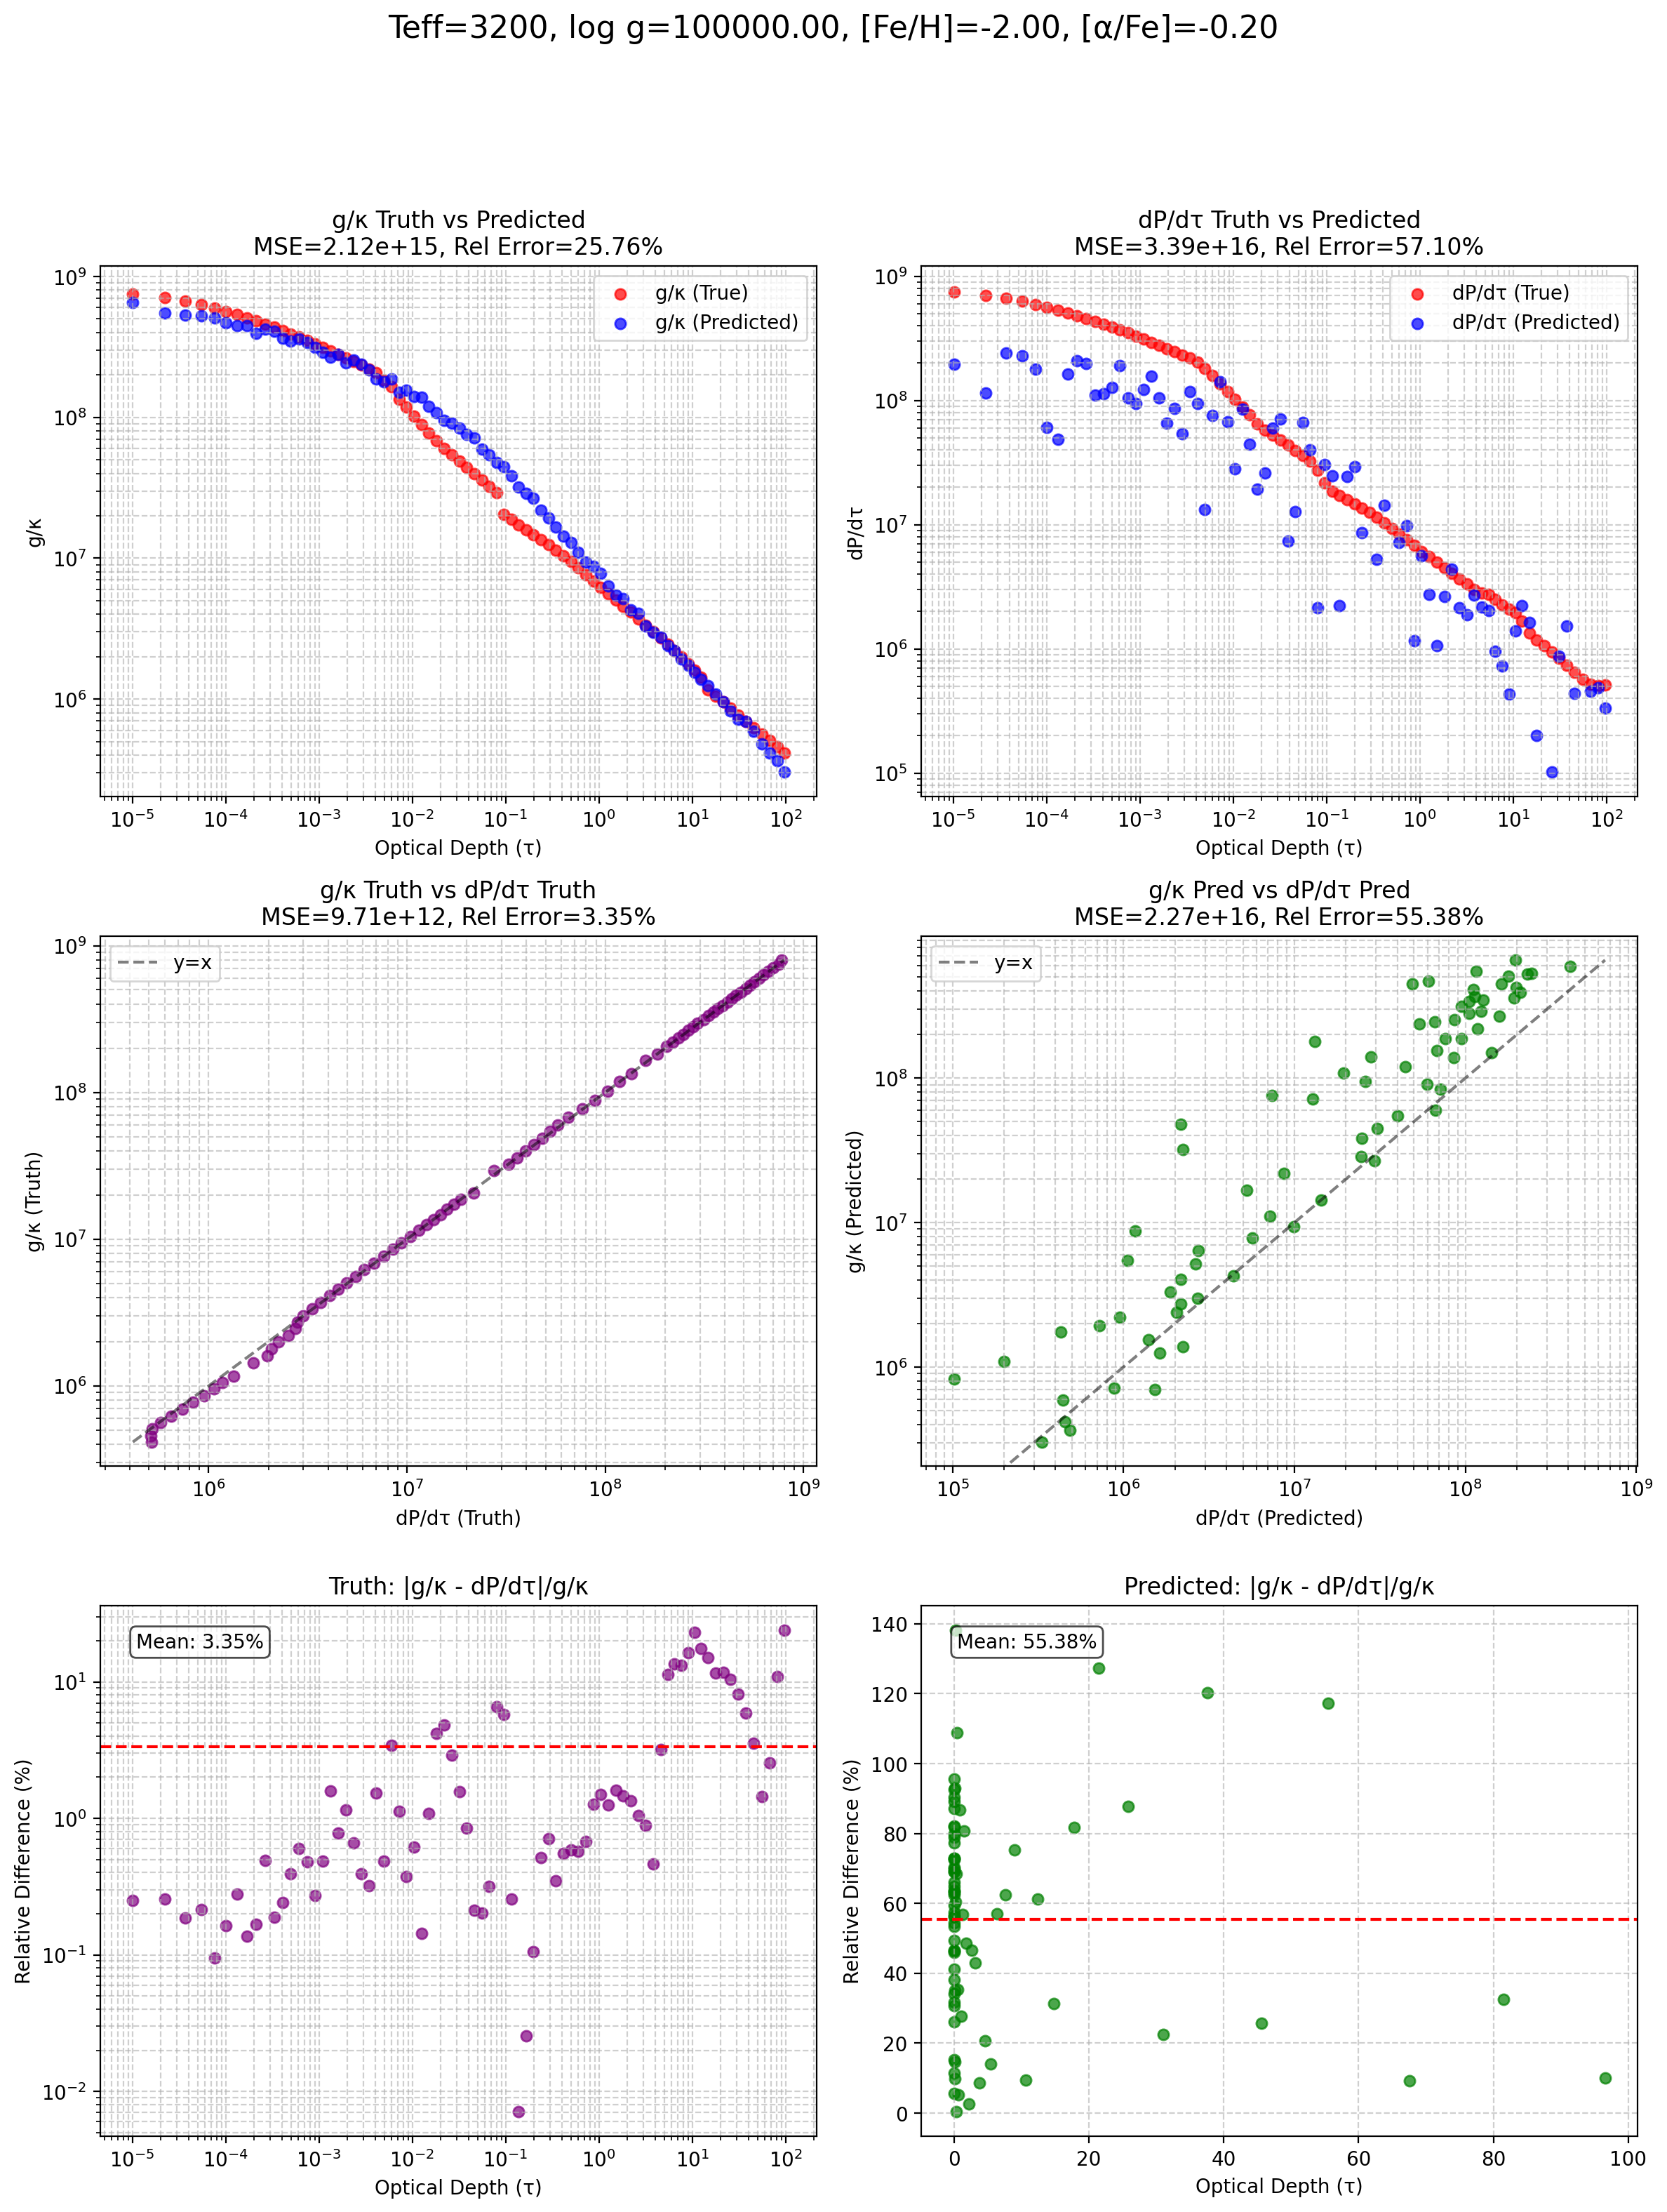

In [42]:
fig = plot_comprehensive_comparison(dP_dtau_predicted, dP_dtau_ground_truth, sample_idx=1)